In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns
from Bio import SeqIO
import glob
import copy
import sys
import pysam
import glob
import os
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
BLOOD_MICROBIOME_PATH = '/home/groups/dpwall/briannac/blood_microbiome/'
FIG_DIR=BLOOD_MICROBIOME_PATH + 'results/herpesvirus/'

colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sys.path.append('/home/groups/dpwall/briannac/blood_microbiome/src')
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'

virus_file = BLOOD_MICROBIOME_PATH + 'data/kraken_align/virus_filtered_species.df' 

## Load / format data

In [3]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t', index_col=1)
df_virus  = pd.read_pickle(virus_file)
df_virus.index = [i[2] for i in df_virus.index]
df_virus = df_virus.transpose()

In [4]:
df_herpesvirus = df_virus[[c for c in df_virus.columns if 'herpesvirus' in c]].copy()
flagstat = pd.read_csv('/home/groups/dpwall/briannac/general_data/ihart_flagstat.csv', index_col=0)

df_herpesvirus_normed = df_herpesvirus[df_herpesvirus.columns[:6]].apply(lambda x: np.array(x)/flagstat.loc[[i.replace('_', '-') for i in df_herpesvirus.index]]['Mapped'].values, axis=0)
df_herpesvirus = df_herpesvirus_normed.apply(lambda x: 3e9*x/np.array([1,150e3, 150e3, 165e3, 165e3, 150e3]), axis=1)

In [5]:
def InheritanceLabels(thresh = .4, HHV  = 'Human betaherpesvirus 6B'):
    df_herpesvirus['relationship'] = bam_mappings.loc[df_herpesvirus.index].relationship
    df_herpesvirus['family'] = bam_mappings.loc[df_herpesvirus.index].family
    labels = ['low' for _ in df_herpesvirus.index]
    for n, i in enumerate(df_herpesvirus.index):
        if df_herpesvirus.loc[i][HHV] < thresh:
            continue
        fam = df_herpesvirus.loc[i].family
        df_fam = df_herpesvirus[(df_herpesvirus.family==fam)]
        if df_herpesvirus.loc[i].relationship=='sibling':
            if sum(df_fam[df_fam.relationship!='sibling'][HHV].values>thresh)>0:
                labels[n] = 'high HHV sample with high HHV parents/offspring'
            elif ('mother' not in df_fam.relationship.values) or ('father' not in df_fam.relationship.values):
                labels[n] = 'high HHV sample, not enough family members to confirm'
            else: labels[n] = 'high HHV child, low HHV parents'
        elif df_herpesvirus.loc[i].relationship!='sibling':
            if sum(df_fam[df_fam.relationship=='sibling'][HHV].values>thresh)>0:
                labels[n] = 'high HHV sample with high HHV parents/offspring'
            else:
                labels[n] = 'high HHV sample, not enough family members to confirm'
    return labels

In [6]:
df_6A = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 6A']])
df_6A.columns = ['read counts']
df_6A['status'] = df_6A['read counts']>.3
df_6A['labels'] = InheritanceLabels(.3, 'Human betaherpesvirus 6A')
df_6A['HHV'] = ['6A_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]


df_6B = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 6B']])
df_6B.columns = ['read counts']
df_6B['status'] = df_6B['read counts']>.3
df_6B['labels'] = InheritanceLabels(.3, 'Human betaherpesvirus 6B')
df_6B['HHV'] = ['6B_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]


df_7 = pd.DataFrame(df_herpesvirus[['Human betaherpesvirus 7']])
df_7.columns = ['read counts']
df_7['status'] = df_7['read counts']>.3
df_7['labels'] = InheritanceLabels(.3, 'Human betaherpesvirus 7')
df_7['HHV'] = ['7_' + str(i) for i in bam_mappings.loc[df_herpesvirus.index].bio_seq_source.values]
df_HHV =  pd.concat([df_6A, df_6B, df_7])
#df_HHV['read counts'] = np.log10(df_HHV['read_counts'] + 1)
df_HHV = df_HHV[['nan' not in i for i in df_HHV['HHV'].values]]


In [25]:
herpes_6a_contig = 'Human betaherpesvirus 6A'
herpes_6b_contig =  'Human betaherpesvirus 6B'
herpes_7_contig =  'Human betaherpesvirus 7'
decoy_contig = 'chrUn_JTFH01000690v1_decoy'

In [27]:
high_7 =  df_herpesvirus[df_herpesvirus[herpes_7_contig]>.4].index #df_HHV[((df_HHV.HHV=='6A_WB') | (df_HHV.HHV=='6A_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index
len(high_7)

icihhv_6a =  df_herpesvirus[df_herpesvirus[herpes_6a_contig]>.4].index #df_HHV[((df_HHV.HHV=='6A_WB') | (df_HHV.HHV=='6A_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index
icihhv_6b = df_HHV[((df_HHV.HHV=='6B_WB') | (df_HHV.HHV=='6B_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index

infected_hhv_6a = set(df_herpesvirus[(df_herpesvirus[herpes_6a_contig]>=1) &
                              (df_herpesvirus[herpes_6a_contig]>=(3*df_herpesvirus[(herpes_6b_contig)]))].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b) #
LCL_hhv_6b_high = set(df_herpesvirus[(df_herpesvirus[herpes_6b_contig]>=.4)].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b) #
LCL_hhv_6b_med = set(df_herpesvirus[(df_herpesvirus[herpes_6b_contig]>=.1)].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b).difference(LCL_hhv_6b_high) #


infected_hhv_6b = set(df_herpesvirus[(df_herpesvirus[herpes_6b_contig]>=1) & 
                              (df_herpesvirus[herpes_6b_contig]>=(3*df_herpesvirus[(herpes_6a_contig)]))].index).difference(['03C16028']).difference(
    icihhv_6a).difference(icihhv_6b).difference(LCL_hhv_6b_high).difference(LCL_hhv_6b_med) #
#infected_both = set(pairings_df[(pairings_df[(herpes_6a_contig, herpes_6a_contig)]>=1) & 
#                                (pairings_df[(herpes_6b_contig, herpes_6b_contig)]>=1)].index).difference(
#    ['03C16028']).difference(infected_hhv_6a).difference(icihhv_6a).difference(infected_hhv_6b) #
                                                                                           
other = list(set(df_HHV.index).difference(icihhv_6a).difference(icihhv_6b).difference(infected_hhv_6a).difference(infected_hhv_6b).difference(LCL_hhv_6b_high).difference(LCL_hhv_6b_med))

In [80]:
icihhv_6a

Index(['06C54349', '06C54347', '06C53151', '06C53149', '06C53148', '04C37990',
       '03C16818', '03C16815', '03C16634', '03C16633', '03C16632', '03C16623',
       '03C16621', '03C16028', '02C11465'],
      dtype='object')

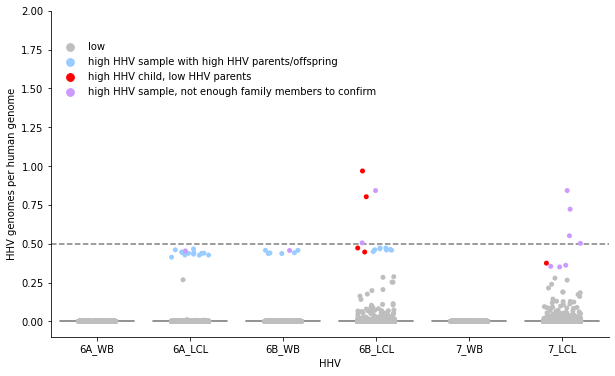

In [9]:
f, ax = plt.subplots(figsize=(10,6))
sns.set_palette(['#BEBEBE', '#99CCFF', '#FF0000', '#CC99FF'])
sns.stripplot(data =df_HHV, x='HHV', y='read counts', hue='labels', jitter=.2)
sns.boxplot(data =df_HHV, x='HHV', y='read counts', color='#ECECEC', showfliers=False)

#plt.yscale('symlog', linthresh=1)
plt.ylim(-.1,2)
plt.hlines(y=.5, xmin=-.5, xmax=5.5, color='grey', linestyle='dashed')
ax.legend(loc='center left', bbox_to_anchor=(0, .82), frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('HHV genomes per human genome')
plt.savefig(FIG_DIR + 'iciHHV_read_counts.svg')
plt.show()

In [81]:
fam = bam_mappings.loc['03C16621'].family
df_herpesvirus.loc[bam_mappings[bam_mappings.family==fam].index]
#bam_mappings.loc[bam_mappings[bam_mappings.family==fam].index][['relationship', 'bio_seq_source']]

,Murid betaherpesvirus 1,Human betaherpesvirus 7,Human gammaherpesvirus 4,Human betaherpesvirus 6A,Human betaherpesvirus 6B,Macacine gammaherpesvirus 4,relationship,family
sample_id,,,,,,,,
03C16621,0.000000,0.0,0.000021,0.446313,0.017902,0.000000,sibling,AU0598
03C16622,15.802294,0.0,0.095067,0.000000,0.000000,0.000000,mother,AU0598
03C16623,14.584161,0.0,0.106659,0.440928,0.016308,0.000073,father,AU0598
03C16624,3.439865,0.0,0.190981,0.000042,0.000000,0.000161,sibling,AU0598
04C37990,6.174353,0.0,0.052832,0.438024,0.017120,0.000021,sibling,AU0598


In [66]:
df_herpesvirus.sort_values(['Human betaherpesvirus 7'])[-40:]

,Murid betaherpesvirus 1,Human betaherpesvirus 7,Human gammaherpesvirus 4,Human betaherpesvirus 6A,Human betaherpesvirus 6B,Macacine gammaherpesvirus 4,relationship,family
07C66648,3.252376,0.128664,0.056136,0.000079,0.000217,0.000065,sibling,AU1923
HI0609,17.062449,0.129948,0.041928,0.000000,0.000000,0.000045,sibling,AU0132
07C62324,3.263489,0.143245,0.045885,0.000000,0.000870,0.000000,sibling,AU1910
07C65280,8.764513,0.160371,0.039596,0.000000,0.000000,0.000058,mother,AU1779
09C98429,9.776618,0.172872,0.025397,0.000000,0.000000,0.000022,sibling,AU2757
05C45401,12.010479,0.184588,0.044332,0.000000,0.000000,0.000053,mother,AU1547
07C68213,18.204931,0.187778,0.015850,0.000000,0.000000,0.000000,sibling,AU1985
08C78111,2.883578,0.189393,0.047368,0.000489,0.071810,0.000038,sibling,AU2238
09C80376,15.340016,0.214479,0.038913,0.000000,0.000000,0.000051,sibling,AU2229
07C69550,15.913060,0.238802,0.019350,0.000000,0.000000,0.000021,mother,AU1647


In [164]:
df_herpesvirus.sort_values('Human betaherpesvirus 6A')[::-1][:20]

,Murid betaherpesvirus 1,Human betaherpesvirus 7,Human gammaherpesvirus 4,Human betaherpesvirus 6A,Human betaherpesvirus 6B,Macacine gammaherpesvirus 4,relationship,family
03C16028,21.892079,0.000292,0.115858,3.406164,338.222090,0.000122,sibling,AU0164
06C54347,10.175882,0.000000,0.013590,0.466467,0.017063,0.000000,mother,AU1608
06C54349,15.261044,0.000000,0.046775,0.460282,0.017712,0.000051,sibling,AU1608
02C11465,19.160628,0.000000,0.015442,0.453700,0.016490,0.000000,father,AU0549
03C16621,0.000000,0.000000,0.000021,0.446313,0.017902,0.000000,sibling,AU0598
06C53151,7.384335,0.000000,0.109140,0.444201,0.017185,0.000123,father,AU1655
03C16623,14.584161,0.000000,0.106659,0.440928,0.016308,0.000073,father,AU0598
06C53148,3.664678,0.017297,0.044929,0.439228,0.015725,0.000024,sibling,AU1655
06C53149,10.459537,0.000000,0.132418,0.438181,0.017221,0.000093,sibling,AU1655
04C37990,6.174353,0.000000,0.052832,0.438024,0.017120,0.000021,sibling,AU0598


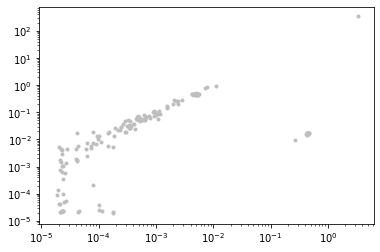

In [150]:
plt.plot(df_herpesvirus['Human betaherpesvirus 6A'], df_herpesvirus['Human betaherpesvirus 6B'], '.')
plt.xl(-.1,1)
plt.ylim(-.1,1)


In [13]:
herpes_6a_contig = 'Human betaherpesvirus 6A'
herpes_6b_contig = 'Human betaherpesvirus 6B'
herpes_7_contig = 'Human betaherpesvirus 7'
#decoy_contig = 'chrUn_JTFH01000690v1_decoy'

In [26]:
high_7 =  df_herpesvirus[df_herpesvirus[herpes_7_contig]>5000].index #df_HHV[((df_HHV.HHV=='6A_WB') | (df_HHV.HHV=='6A_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index
len(high_7)

icihhv_6a =  df_herpesvirus[df_herpesvirus[herpes_6a_contig]>1000].index #df_HHV[((df_HHV.HHV=='6A_WB') | (df_HHV.HHV=='6A_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index
icihhv_6b = df_HHV[((df_HHV.HHV=='6B_WB') | (df_HHV.HHV=='6B_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index

infected_hhv_6a = set(df_herpesvirus[(df_herpesvirus[herpes_6a_contig]>=1) &
                              (df_herpesvirus[herpes_6a_contig]>=(3*df_herpesvirus[(herpes_6b_contig)]))].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b) #
LCL_hhv_6b_high = set(df_herpesvirus[(df_herpesvirus[herpes_6b_contig]>=10000)].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b) #
LCL_hhv_6b_med = set(df_herpesvirus[(df_herpesvirus[herpes_6b_contig]>=1000)].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b).difference(LCL_hhv_6b_high) #


infected_hhv_6b = set(df_herpesvirus[(df_herpesvirus[herpes_6b_contig]>=1) & 
                              (df_herpesvirus[herpes_6b_contig]>=(3*df_herpesvirus[(herpes_6a_contig)]))].index).difference(['03C16028']).difference(
    icihhv_6a).difference(icihhv_6b).difference(LCL_hhv_6b_high).difference(LCL_hhv_6b_med) #
#infected_both = set(pairings_df[(pairings_df[(herpes_6a_contig, herpes_6a_contig)]>=1) & 
#                                (pairings_df[(herpes_6b_contig, herpes_6b_contig)]>=1)].index).difference(
#    ['03C16028']).difference(infected_hhv_6a).difference(icihhv_6a).difference(infected_hhv_6b) #
                                                                                           
other = list(set(df_HHV.index).difference(icihhv_6a).difference(icihhv_6b).difference(infected_hhv_6a).difference(infected_hhv_6b).difference(LCL_hhv_6b_high).difference(LCL_hhv_6b_med))

In [29]:
df_herpesvirus.loc[high_7]

,Murid betaherpesvirus 1,Human betaherpesvirus 7,Human gammaherpesvirus 4,Human betaherpesvirus 6A,Human betaherpesvirus 6B,Macacine gammaherpesvirus 4,Papiine gammaherpesvirus 1,Cyprinid herpesvirus 1,relationship,family
HI0609,5,5712,1843,0,0,2,6,0,sibling,AU0132
HI0366,7,6045,824,0,0,1,2,2,sibling,AU0325
09C98429,3,7957,1169,0,0,1,3,5,sibling,AU2757
09C80376,4,8389,1522,0,0,2,2,3,sibling,AU2229
08C78111,1,9852,2464,28,4109,2,2,7,sibling,AU2238
07C69550,10,22510,1824,0,0,2,2,6,mother,AU1647
07C68436,1,27224,624,0,6,1,0,5,father,AU1749
07C68213,5,7736,653,0,0,0,0,9,sibling,AU1985
07C66954,11,8277,3321,0,159,2,8,13,sibling,AU2004
07C66834,3,14292,1034,0,0,1,0,3,father,AU1813


In [15]:
h6a_high = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6A']>=1e4].index
h6a_med = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>=1e3) & (df_herpesvirus['Human betaherpesvirus 6A']<1e4)].index
h6a_low = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6A']>=1e1) & (df_herpesvirus['Human betaherpesvirus 6A']<1e3)].index


h6b_high = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 6B']>=1e4].index
h6b_med = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>=1e3) & (df_herpesvirus['Human betaherpesvirus 6B']<1e4)].index
h6b_low = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 6B']>=1e1) & (df_herpesvirus['Human betaherpesvirus 6B']<1e3)].index


h7_high = df_herpesvirus[df_herpesvirus['Human betaherpesvirus 7']>=1e4].index
h7_med = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 7']>=1e3) & (df_herpesvirus['Human betaherpesvirus 7']<1e4)].index
h7_low = df_herpesvirus[(df_herpesvirus['Human betaherpesvirus 7']>=1e1) & (df_herpesvirus['Human betaherpesvirus 7']<1e3)].index

In [16]:
# Read in coverage dictionary.
coverages = np.load('/home/groups/dpwall/briannac/blood_microbiome/results/herpesvirus/coverages.npy', allow_pickle=True)
coverages_dict = coverages.item()

In [17]:
herpes_6a_contig = 'kraken:taxid|32603|NC_001664.4'
herpes_6b_contig = 'kraken:taxid|32604|NC_000898.1'
herpes_7_contig = 'kraken:taxid|10372|NC_001716.2'
decoy_contig = 'chrUn_JTFH01000690v1_decoy'

In [18]:
pairing_cols = list(set([tuple(p) for k in coverages_dict.keys() for p in coverages_dict[k].keys()]))
pairings_df = pd.DataFrame([[sum(coverages_dict[k][p][0].values())/150 if p in coverages_dict[k] else 0 for p in pairing_cols] for k in coverages_dict.keys()], columns=pairing_cols)
pairings_df.index = list(coverages_dict.keys())


/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


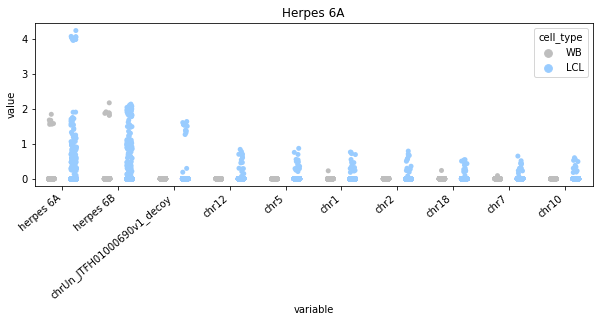

/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


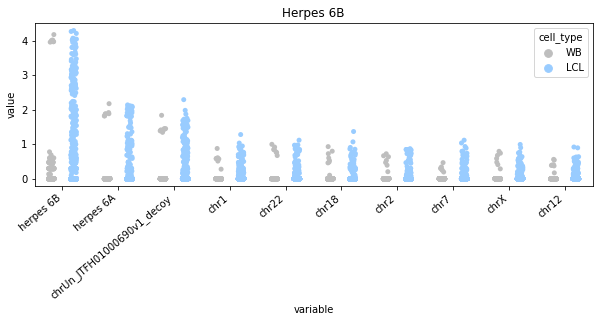

/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


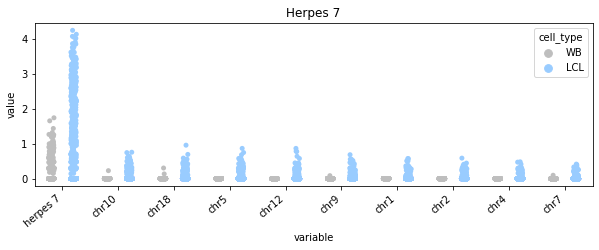

In [19]:
for contig in [herpes_6a_contig, herpes_6b_contig, herpes_7_contig]:
    pairings_df_contig = pairings_df[pairings_df.columns[[(c[1]==contig) | (c[0]==contig) for c in pairings_df.columns]]].copy()
    pairings_df_contig = np.log10(pairings_df_contig[np.log10(pairings_df_contig.max(axis=1))<100]+1)

    pairings_df_contig = pairings_df_contig[pairings_df_contig.sum().sort_values(ascending=False)[:10].keys()]
    pairings_df_contig.columns = [c[0] if c[1]==contig else c[1] for c in pairings_df_contig.columns]
    pairings_df_contig['cell_type'] = bam_mappings.loc[pairings_df_contig.index].bio_seq_source
    pairings_melt = pairings_df_contig.melt(id_vars=['cell_type'])
    pairings_melt = pairings_melt.replace(herpes_6a_contig, 'herpes 6A').replace(herpes_6b_contig, 'herpes 6B').replace(herpes_7_contig, 'herpes 7')
    plt.figure(figsize=(10,3))
    ax = sns.stripplot(data=pairings_melt,x='variable', y='value', hue='cell_type', dodge=True)
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 40, ha='right')
    #plt.yscale('symlog')
    if contig==herpes_6a_contig: plt.title('Herpes 6A')
    if contig==herpes_6b_contig: plt.title('Herpes 6B')
    if contig==herpes_7_contig: plt.title('Herpes 7')
    plt.show()

In [32]:
high_7 =  pairings_df[pairings_df[(herpes_7_contig, herpes_7_contig)]>5000].index #df_HHV[((df_HHV.HHV=='6A_WB') | (df_HHV.HHV=='6A_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index
len(high_7)

11

In [24]:
high_7 =  pairings_df[pairings_df[(herpes_7_contig, herpes_7_contig)]>5000].index #df_HHV[((df_HHV.HHV=='6A_WB') | (df_HHV.HHV=='6A_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index
len(high_7)

icihhv_6a =  pairings_df[pairings_df[(herpes_6a_contig, herpes_6a_contig)]>1000].index #df_HHV[((df_HHV.HHV=='6A_WB') | (df_HHV.HHV=='6A_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index
icihhv_6b = df_HHV[((df_HHV.HHV=='6B_WB') | (df_HHV.HHV=='6B_LCL')) & (df_HHV.labels=='high HHV sample with high HHV parents/offspring')].index

infected_hhv_6a = set(pairings_df[(pairings_df[(herpes_6a_contig, herpes_6a_contig)]>=1) &
                              (pairings_df[(herpes_6a_contig, herpes_6a_contig)]>=(3*pairings_df[(herpes_6b_contig, herpes_6b_contig)]))].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b) #
LCL_hhv_6b_high = set(pairings_df[(pairings_df[(herpes_6b_contig, herpes_6b_contig)]>=10000)].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b) #
LCL_hhv_6b_med = set(pairings_df[(pairings_df[(herpes_6b_contig, herpes_6b_contig)]>=1000)].index).difference(['03C16028']).difference(icihhv_6a).difference(icihhv_6b).difference(LCL_hhv_6b_high) #


infected_hhv_6b = set(pairings_df[(pairings_df[(herpes_6b_contig, herpes_6b_contig)]>=1) & 
                              (pairings_df[(herpes_6b_contig, herpes_6b_contig)]>=(3*pairings_df[(herpes_6a_contig, herpes_6a_contig)]))].index).difference(['03C16028']).difference(
    icihhv_6a).difference(icihhv_6b).difference(LCL_hhv_6b_high).difference(LCL_hhv_6b_med) #
#infected_both = set(pairings_df[(pairings_df[(herpes_6a_contig, herpes_6a_contig)]>=1) & 
#                                (pairings_df[(herpes_6b_contig, herpes_6b_contig)]>=1)].index).difference(
#    ['03C16028']).difference(infected_hhv_6a).difference(icihhv_6a).difference(infected_hhv_6b) #
                                                                                           
other = list(set(pairings_df.index).difference(icihhv_6a).difference(icihhv_6b).difference(infected_hhv_6a).difference(infected_hhv_6b).difference(LCL_hhv_6b_high).difference(LCL_hhv_6b_med))

In [22]:
# One sample is consistent with iciHHV-6A homozygous. Who is this?

In [23]:
df_virus.sort_values('Human betaherpesvirus 6A')[::-1]['Human betaherpesvirus 6A'][:5]

03C16028    154033
02C11465     35163
03C16621     23809
04C37990     23411
06C54347     22691
Name: Human betaherpesvirus 6A, dtype: int64

In [24]:
print(bam_mappings.loc['02C11465'].relationship)
df_virus.loc[bam_mappings[bam_mappings.family==bam_mappings.loc['02C11465'].family].index]['Human betaherpesvirus 6A']


father


sample_id
02C11465    35163
02C11466        0
02C11467        0
02C11468       32
Name: Human betaherpesvirus 6A, dtype: int64

In [25]:
# It's a father, who didn't pass down the virus to either of his kids. So he is either heterozygous or with active infection.

In [26]:
a = pairings_df[(herpes_6b_contig, herpes_6b_contig)][LCL_hhv_6b].values
plt.hist(a[a>1])
#plt.yscale('log')
plt.ylim(0,20)

NameError: name 'LCL_hhv_6b' is not defined

# Pairings

In [67]:
sns.color_palette("Set1", 8)


[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)]

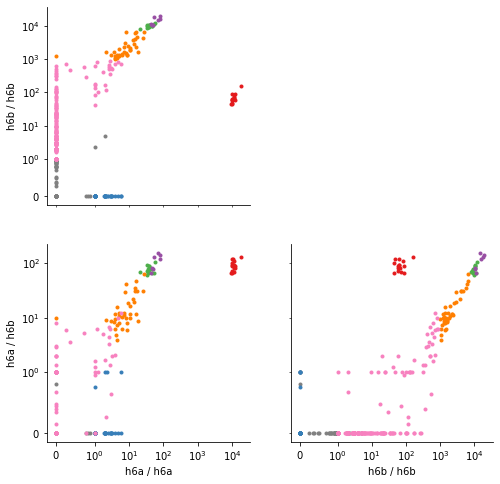

In [70]:
icihhv_6a
icihhv_6b
infected_hhv_6a
LCL_hhv_6b_high
LCL_hhv_6b_med
infected_hhv_6b
def plotContigs(pair1, pair2, ax):
    ax.plot(pairings_df.loc[other][pair1].values, pairings_df.loc[other][pair2].values, '.', color='#808080')
    ax.plot(pairings_df.loc[icihhv_6a][pair1].values, pairings_df.loc[icihhv_6a][pair2].values, '.', color=sns.color_palette("Set1")[0])
    ax.plot(pairings_df.loc[infected_hhv_6a][pair1].values, pairings_df.loc[infected_hhv_6a][pair2].values, '.', color=sns.color_palette("Set1")[1])

    ax.plot(pairings_df.loc[icihhv_6b][pair1].values, pairings_df.loc[icihhv_6b][pair2].values, '.', color=sns.color_palette("Set1")[2])
    #ax.plot(pairings_df.loc[noninherited_6a][pair1].values, pairings_df.loc[noninherited_6a][pair2].values, 'x', color='red')
    ax.plot(pairings_df.loc[LCL_hhv_6b_high][pair1].values, pairings_df.loc[LCL_hhv_6b_high][pair2].values, '.', color=sns.color_palette("Set1")[3])
    ax.plot(pairings_df.loc[LCL_hhv_6b_med][pair1].values, pairings_df.loc[LCL_hhv_6b_med][pair2].values, '.', color=sns.color_palette("Set1")[4])
    ax.plot(pairings_df.loc[infected_hhv_6b][pair1].values, pairings_df.loc[infected_hhv_6b][pair2].values, '.', color=sns.color_palette("Set1")[7])
    ax.set_xlabel(' / '.join([p.replace(herpes_6a_contig, 'h6a').replace(herpes_6b_contig, 'h6b').replace(herpes_7_contig, 'h7a').replace(decoy_contig, 'chrDecoy') for p in pair1]))
    ax.set_ylabel(' / '.join([p.replace(herpes_6a_contig, 'h6a').replace(herpes_6b_contig, 'h6b').replace(herpes_7_contig, 'h7a').replace(decoy_contig, 'chrDecoy') for p in pair2]))
    ax.set_xscale('symlog', linthresh=1)
    ax.set_yscale('symlog', linthresh=1)
    
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
for i1, p1 in enumerate([(herpes_6a_contig, herpes_6a_contig), (herpes_6b_contig, herpes_6b_contig), 
           (herpes_6a_contig, herpes_6b_contig)]):#, 
#           (decoy_contig, herpes_6a_contig), (decoy_contig, herpes_6b_contig)]):
    
    for i2, p2 in enumerate([((herpes_6a_contig, herpes_6a_contig)), (herpes_6b_contig, herpes_6b_contig), 
           (herpes_6a_contig, herpes_6b_contig)]):#, 
          # (decoy_contig, herpes_6a_contig), (decoy_contig, herpes_6b_contig)]):
        
        if i1<i2: 
            ax[i2-1, i1].spines['top'].set_visible(False)
            ax[i2-1, i1].spines['right'].set_visible(False)
            plotContigs(p1, p2, ax[i2-1, i1])
            if i1!=0: 
                ax[i2-1, i1].set_ylabel('')
                ax[i2-1, i1].set_yticks([])
            if i2!=2: 
                ax[i2-1,i1].set_xlabel('')
                ax[i2-1,i1].set_xticks([])
                
        

for i in range(1):
    for j in range(i+1,2):
        ax[i,j].axis('off')
plt.savefig(FIG_DIR + 'herpes6_ab_count_correlations.svg', transparent=True)
plt.show()


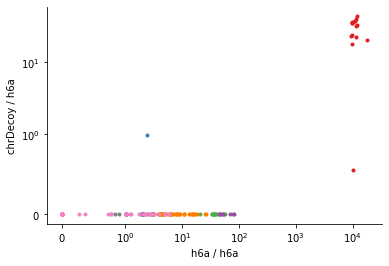

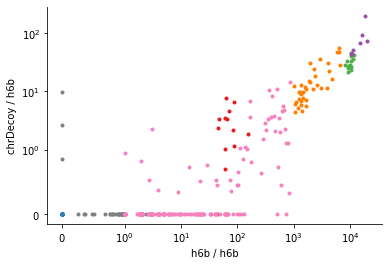

In [79]:
f, ax = plt.subplots()
plotContigs((herpes_6a_contig, herpes_6a_contig), (decoy_contig, herpes_6a_contig), ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(FIG_DIR + 'herpes6a_with_decoy.svg', transparent=True)

plt.show()


f, ax = plt.subplots()
plotContigs((herpes_6b_contig, herpes_6b_contig), (decoy_contig, herpes_6b_contig), ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(FIG_DIR + 'herpes6b_with_decoy.svg', transparent=True)
plt.show()

In [ ]:
# Who's the one weird icihhv-6a sample?

In [ ]:
pairings_df.loc[h6a_high.drop(['03C16028'])][(decoy_contig, herpes_6a_contig)]
# Werid sample is 06C53149

pairings_df.loc[h6a_high.drop(['03C16028'])].sort_values('06C53149', axis=1, ascending=False)
#bam_mappings[bam_mappings.family==bam_mappings.loc['06C53149'].family]

In [336]:
pairings_df

,"(chrUn_JTFH01000424v1_decoy, kraken:taxid|32604|NC_000898.1)","(chr20, kraken:taxid|10372|NC_001716.2)","(chr22_KI270736v1_random, kraken:taxid|32604|NC_000898.1)","(chr7_KI270899v1_alt, kraken:taxid|10372|NC_001716.2)","(chr6_GL000252v2_alt, kraken:taxid|10372|NC_001716.2)","(chr19, kraken:taxid|32603|NC_001664.4)","(chr15, kraken:taxid|32603|NC_001664.4)","(chr19, kraken:taxid|32604|NC_000898.1)","(kraken:taxid|32604|NC_000898.1, kraken:taxid|32604|NC_000898.1)","(chr1, kraken:taxid|32604|NC_000898.1)",...,"(chr6, kraken:taxid|10372|NC_001716.2)","(chr2, kraken:taxid|10372|NC_001716.2)","(chr12_GL877875v1_alt, kraken:taxid|32603|NC_001664.4)","(chr8, kraken:taxid|32604|NC_000898.1)","(chr16, kraken:taxid|32603|NC_001664.4)","(chr21, kraken:taxid|10372|NC_001716.2)","(chr12, kraken:taxid|10372|NC_001716.2)","(chr15, kraken:taxid|10372|NC_001716.2)","(chr22, kraken:taxid|10372|NC_001716.2)","(chr2, kraken:taxid|32603|NC_001664.4)"
MH0143019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.640000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MH0143018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MH0143013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.006667,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MH0143009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MH0143008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
02C10702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02C10543,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02C10542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02C10541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
def coverage_proper_pairs(contig, samples):
    new_samples = set(samples).intersection(coverages_dict.keys())
    pair = (contig, contig)
    coverages_pair1 = [coverages_dict[k][pair][0] for k in new_samples if pair in coverages_dict[k]]
    coverages_pair2 = [coverages_dict[k][pair][1] for k in new_samples if pair in coverages_dict[k]]
    
    for i in range(len(coverages_pair1)):
        total = sum(coverages_pair1[i].values(), 0.0)
        for key in coverages_pair1[i]:
            coverages_pair1[i][key] /= total

        total = sum(coverages_pair2[i].values(), 0.0)
        for key in coverages_pair2[i]:
            coverages_pair2[i][key] /= total
            
    counter_all = [sum([c1, c2], Counter()) for c1, c2 in zip(coverages_pair1, coverages_pair2)]
    
    counter_sum = sum(coverages_pair1 + coverages_pair2, Counter())
    return counter_sum, counter_all


def coverage_pairs_diff_contig(contig1, contig2, samples):
    new_samples = set(samples).intersection(coverages_dict.keys())
    pair = (contig1, contig2)
    coverages_pair1 = [coverages_dict[k][pair][0] for k in new_samples if pair in coverages_dict[k]]
    coverages_pair2 = [coverages_dict[k][pair][1] for k in new_samples if pair in coverages_dict[k]]
    
    for i in range(len(coverages_pair1)):
        total = sum(coverages_pair1[i].values(), 0.0)
        for key in coverages_pair1[i]:
            coverages_pair1[i][key] /= total

        total = sum(coverages_pair2[i].values(), 0.0)
        for key in coverages_pair2[i]:
            coverages_pair2[i][key] /= total
    
    counter1_all = [sum([c], Counter()) for c in coverages_pair1]
    counter1_sum = sum(coverages_pair1, Counter())
    
    counter2_all = [sum([c], Counter()) for c in coverages_pair2]
    counter2_sum = sum(coverages_pair2, Counter())
    
    return counter1_sum, counter1_all, counter2_sum, counter2_all


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


avg_window = 100


def PlotCoverages(primary_contig, samples, color, primary_contig_name, samples_name):

    cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6A (mated with HHV-6A)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6A_6A.svg' % samples_name, transparent=True)
    plt.show()

    cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6B (mated with HHV-6B)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6B_6B.svg' % samples_name, transparent=True)

    plt.show()


    cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all1):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6A (mated with HHV-6B)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6A_6B.svg' % samples_name, transparent=True)
    plt.show()

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all2):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-6B (mated with HHV-6A)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_6B_6A.svg' % (samples_name), transparent=True)
    plt.show()



    cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, primary_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all1):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(2000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(2000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color=color)
    plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('Decoy (mated with %s)' % primary_contig_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_decoy_%s.svg' % (samples_name, primary_contig_name), transparent=True)
    plt.show()

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all2):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('%s (mated with decoy)' % primary_contig_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.savefig(FIG_DIR + '%s_%s_decoy.svg' % (samples_name, primary_contig_name), transparent=True)
    plt.show()

    


In [46]:
def coverage_proper_pairs(contig, samples):
    new_samples = set(samples).intersection(coverages_dict.keys())
    pair = (contig, contig)
    coverages_pair1 = [coverages_dict[k][pair][0] for k in new_samples if pair in coverages_dict[k]]
    coverages_pair2 = [coverages_dict[k][pair][1] for k in new_samples if pair in coverages_dict[k]]
    
    for i in range(len(coverages_pair1)):
        total = sum(coverages_pair1[i].values(), 0.0)
        for key in coverages_pair1[i]:
            coverages_pair1[i][key] /= total

        total = sum(coverages_pair2[i].values(), 0.0)
        for key in coverages_pair2[i]:
            coverages_pair2[i][key] /= total
            
    counter_all = [sum([c1, c2], Counter()) for c1, c2 in zip(coverages_pair1, coverages_pair2)]
    
    counter_sum = sum(coverages_pair1 + coverages_pair2, Counter())
    return counter_sum, counter_all


def coverage_pairs_diff_contig(contig1, contig2, samples):
    new_samples = set(samples).intersection(coverages_dict.keys())
    pair = (contig1, contig2)
    coverages_pair1 = [coverages_dict[k][pair][0] for k in new_samples if pair in coverages_dict[k]]
    coverages_pair2 = [coverages_dict[k][pair][1] for k in new_samples if pair in coverages_dict[k]]
    
    for i in range(len(coverages_pair1)):
        total = sum(coverages_pair1[i].values(), 0.0)
        for key in coverages_pair1[i]:
            coverages_pair1[i][key] /= total

        total = sum(coverages_pair2[i].values(), 0.0)
        for key in coverages_pair2[i]:
            coverages_pair2[i][key] /= total
    
    counter1_all = [sum([c], Counter()) for c in coverages_pair1]
    counter1_sum = sum(coverages_pair1, Counter())
    
    counter2_all = [sum([c], Counter()) for c in coverages_pair2]
    counter2_sum = sum(coverages_pair2, Counter())
    
    return counter1_sum, counter1_all, counter2_sum, counter2_all


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


avg_window = 100


def Plot7Coverages(primary_contig, samples, color, primary_contig_name, samples_name):

    cov_sum, cov_all  = coverage_proper_pairs(herpes_7_contig, samples)

    f, ax = plt.subplots(figsize=(20,3))
    for idx, cov_i in enumerate(cov_all):
        loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(155000)}
        plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
    loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(155000)}
    print(max([k for k in loci_cov_dict.keys() if loci_cov_dict[k]>0]))
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color=color)
    plt.yscale('symlog', linthresh=1e-7)
    plt.xlabel('loci')
    plt.ylabel('coverage (normalized)')
    plt.title('HHV-7 (mated with HHV-7)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.show()


 
    


In [41]:
herpes_7_contig

'kraken:taxid|10372|NC_001716.2'

153079


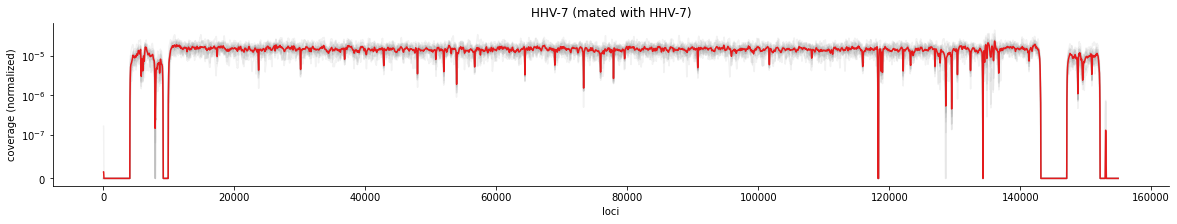

In [47]:
Plot7Coverages(herpes_7_contig, high_7, sns.color_palette("Set1")[0], 'HHV-7', '7')

# Proper Pairs

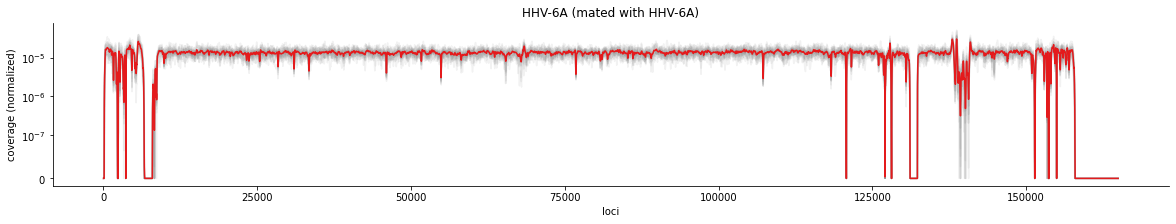

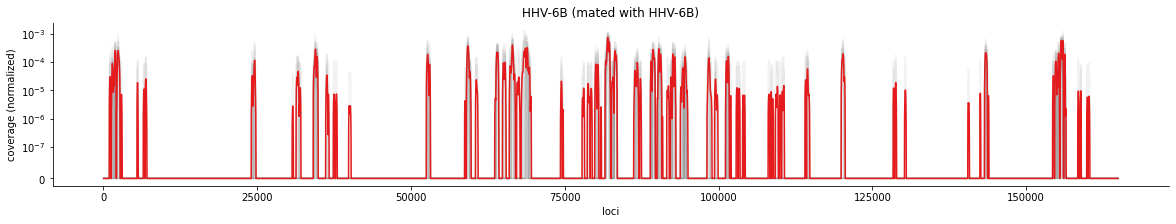

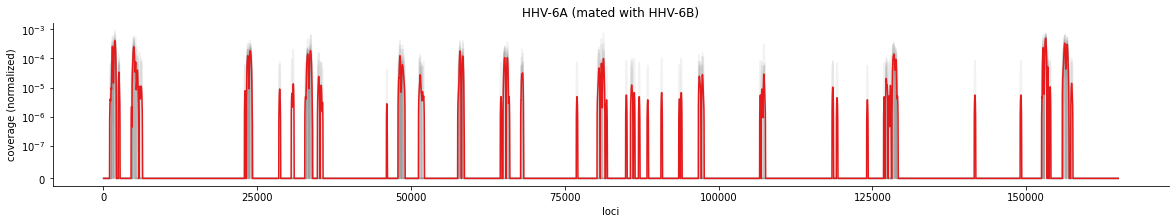

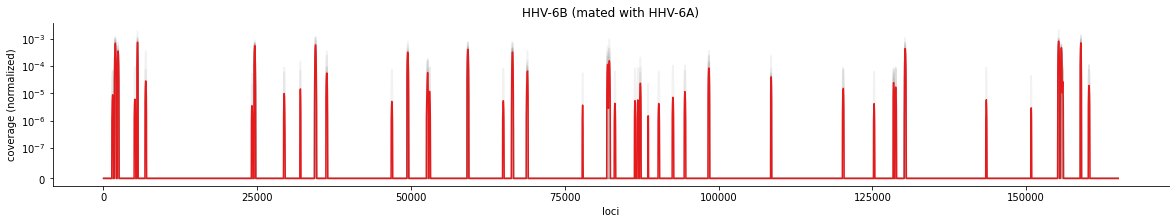

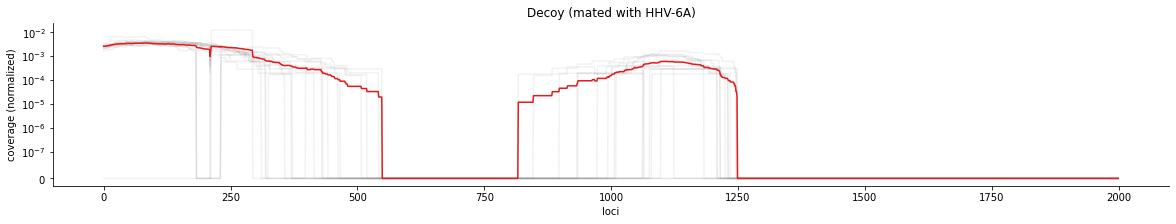

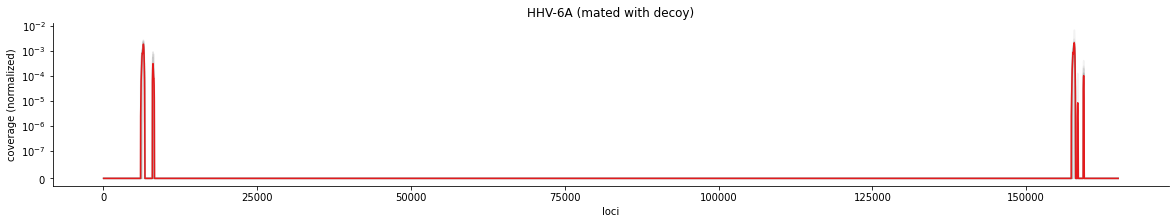

In [81]:
PlotCoverages(herpes_6a_contig, icihhv_6a, sns.color_palette("Set1")[0], 'HHV-6A', 'ici6A')

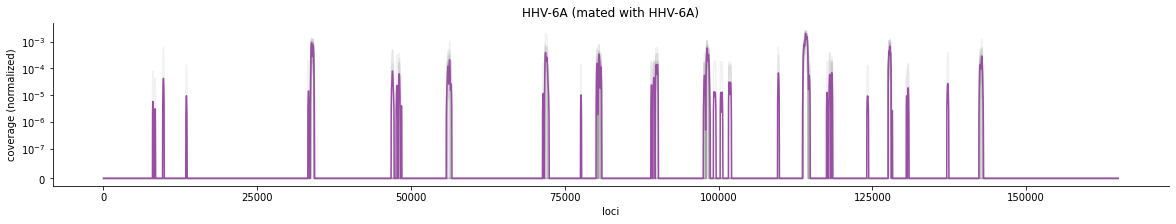

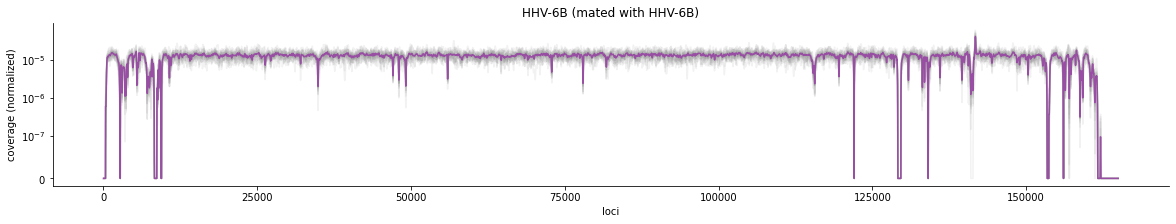

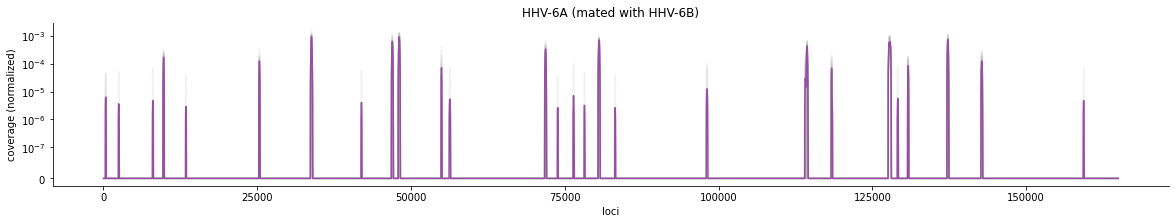

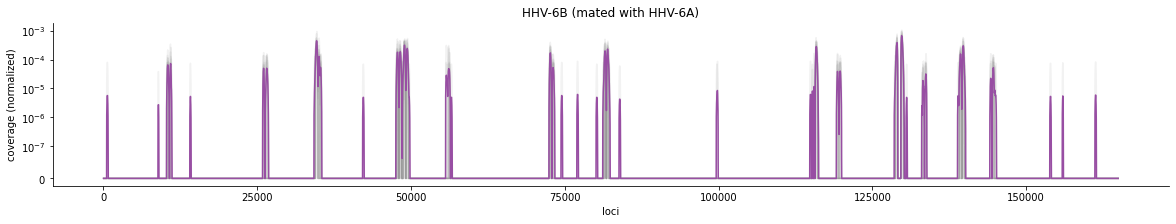

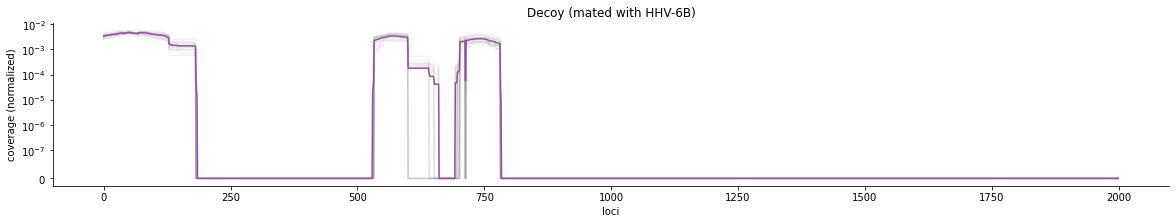

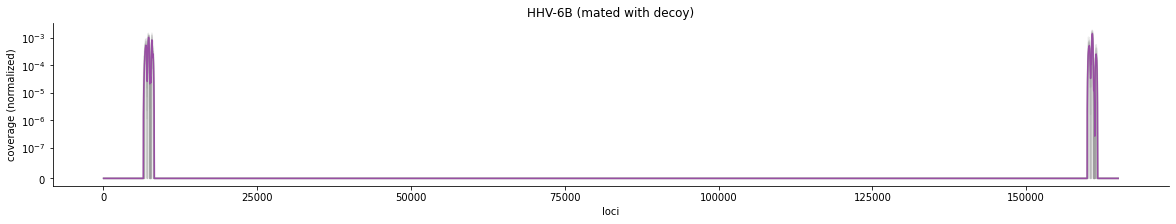

In [82]:
PlotCoverages(herpes_6b_contig, icihhv_6b, sns.color_palette("Set1")[3], 'HHV-6B', 'ici6B')

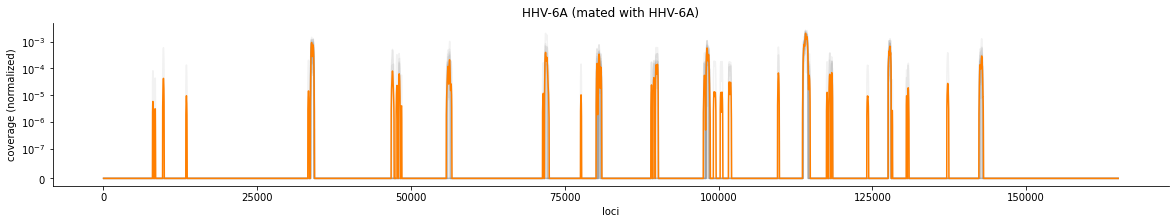

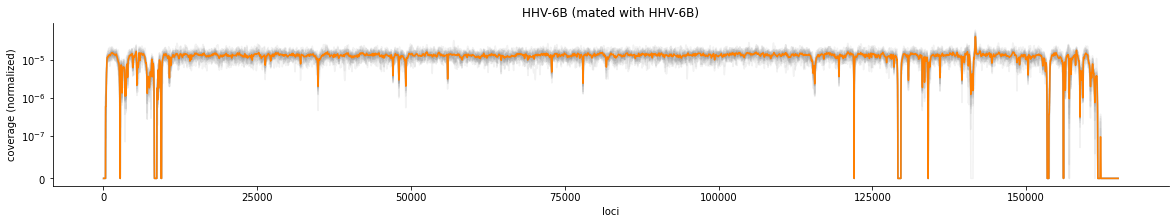

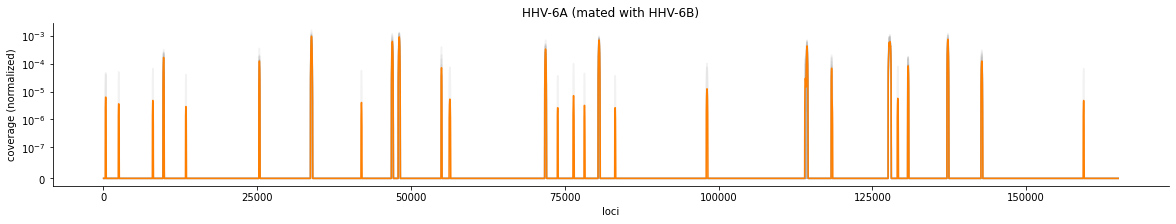

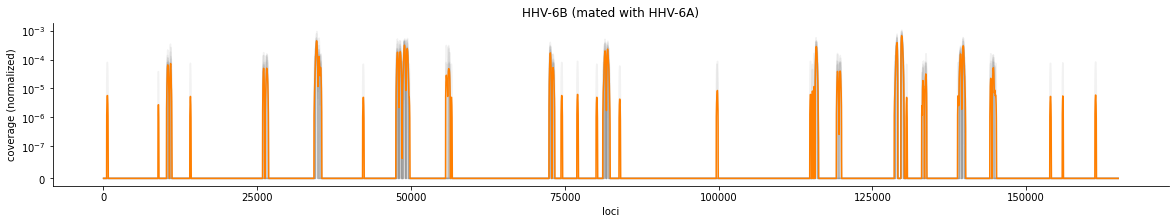

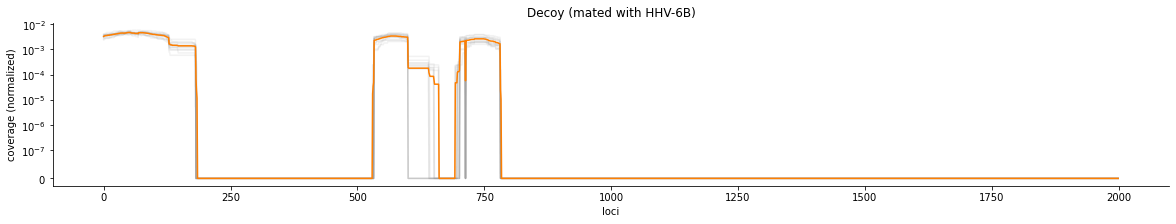

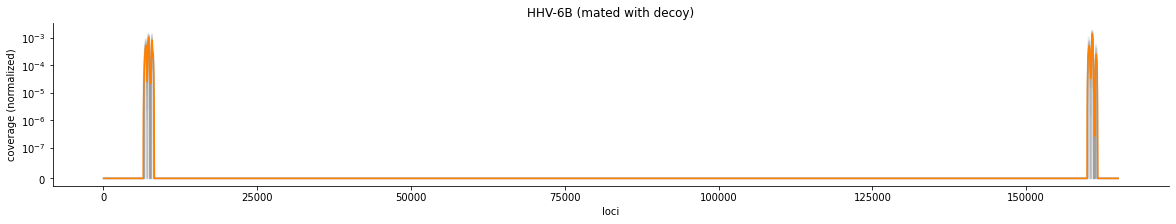

In [83]:
PlotCoverages(herpes_6b_contig, icihhv_6b, sns.color_palette("Set1")[4], 'HHV-6B', 'LCL_6B_med')

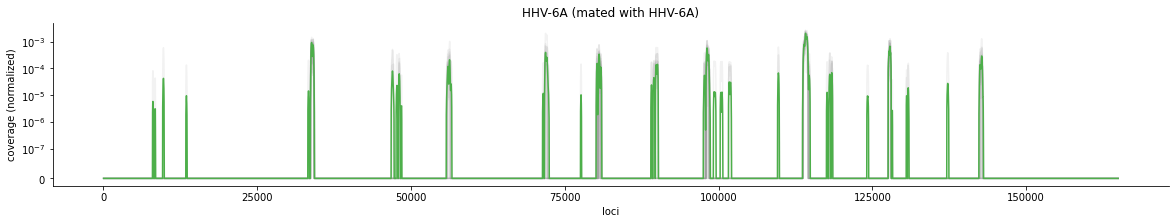

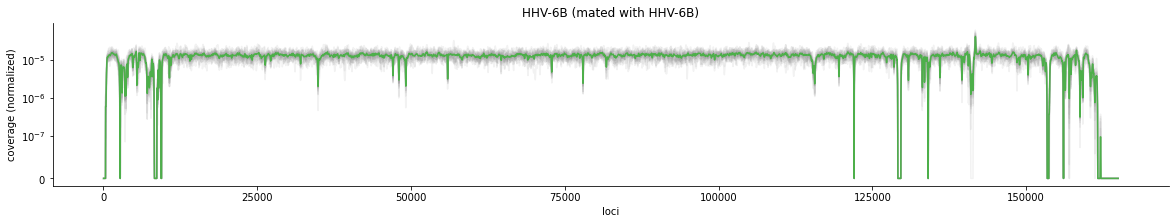

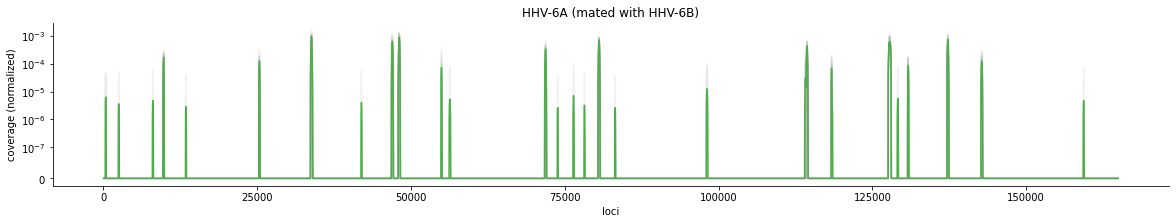

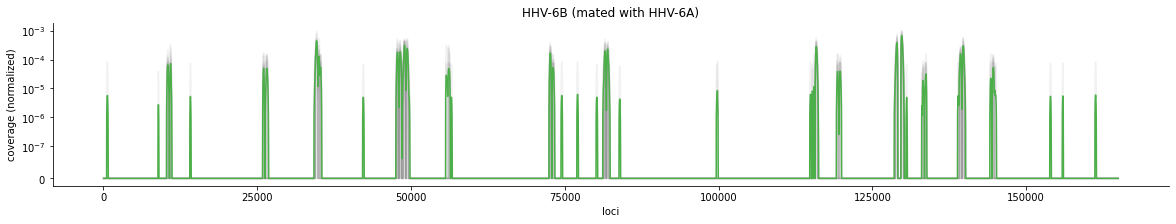

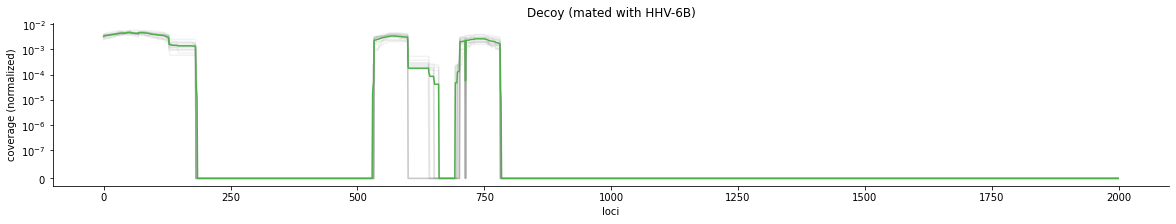

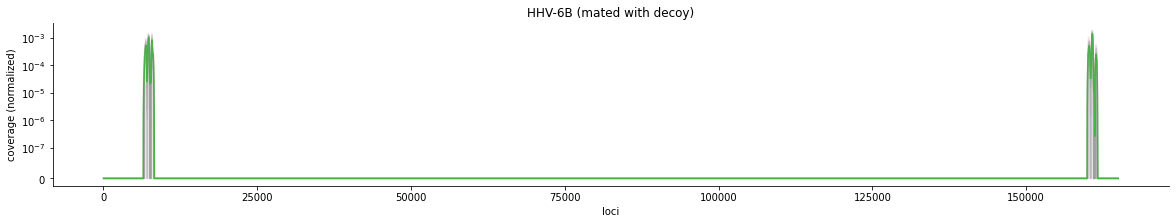

In [84]:
PlotCoverages(herpes_6b_contig, icihhv_6b, sns.color_palette("Set1")[2], 'HHV-6B', 'LCL_6B_high')

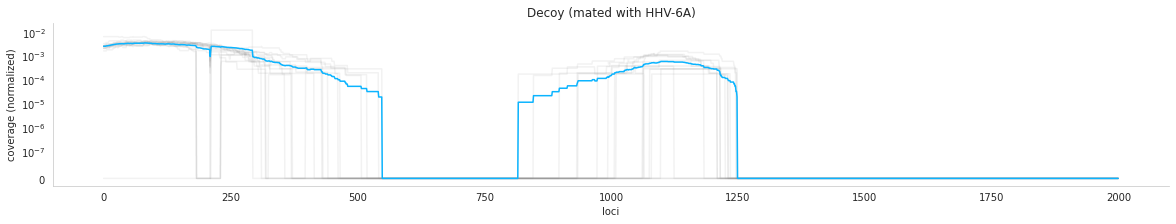

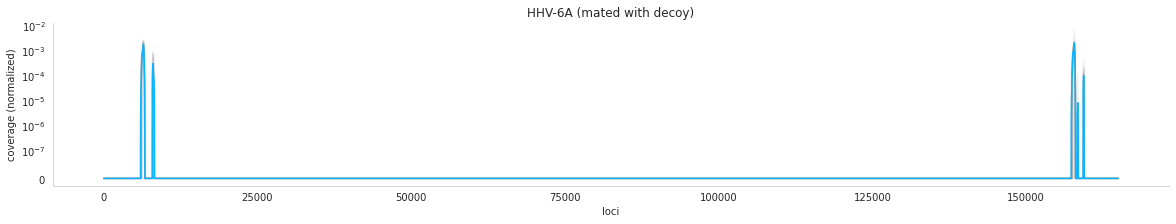

In [76]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6a_contig, icihhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(2000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(2000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with decoy)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

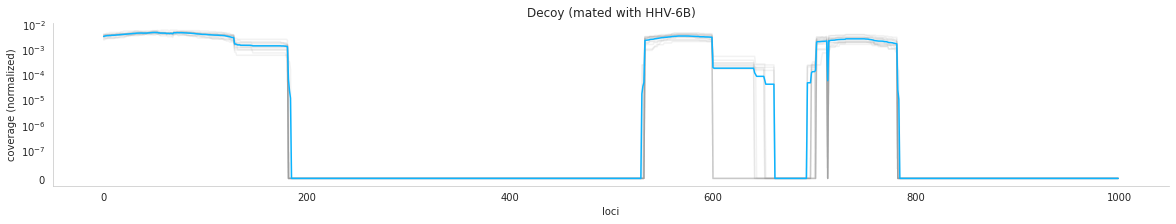

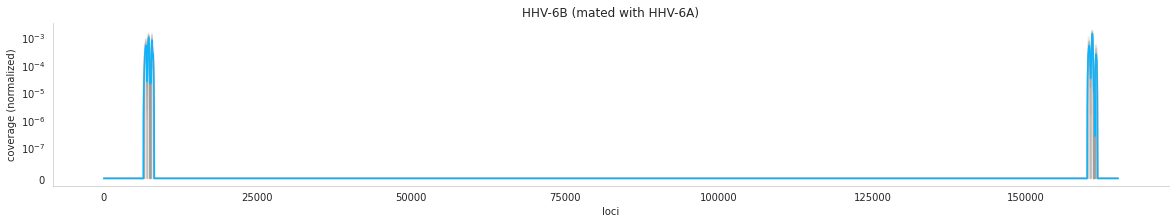

In [73]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, icihhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(1000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

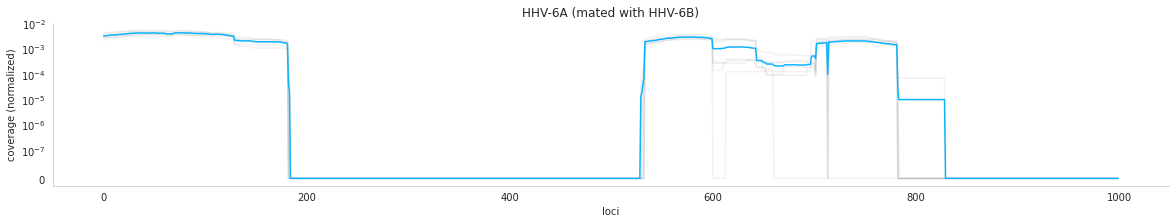

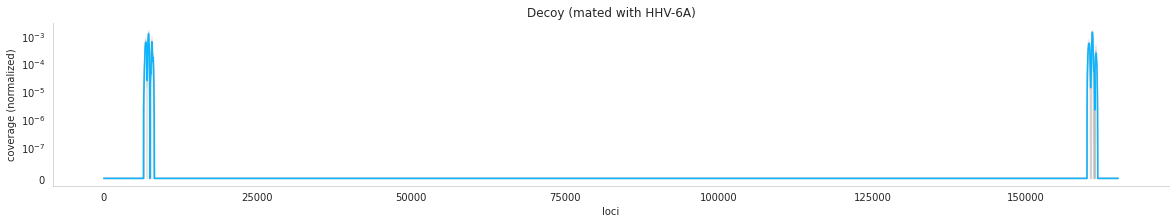

In [86]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, LCL_hhv_6b_high)


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(1000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

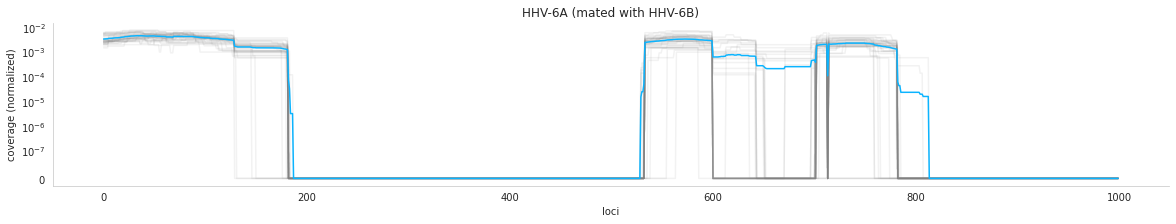

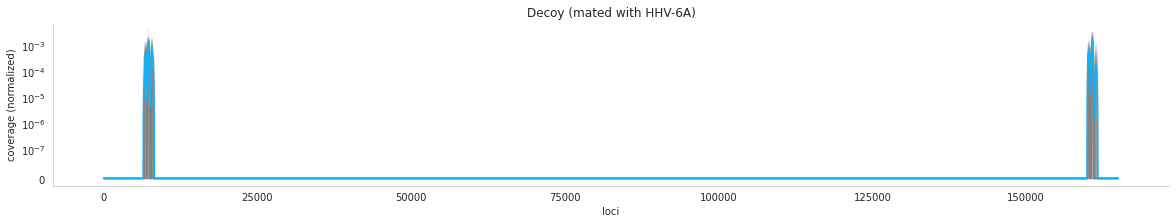

In [88]:
cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, LCL_hhv_6b_med)


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(1000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

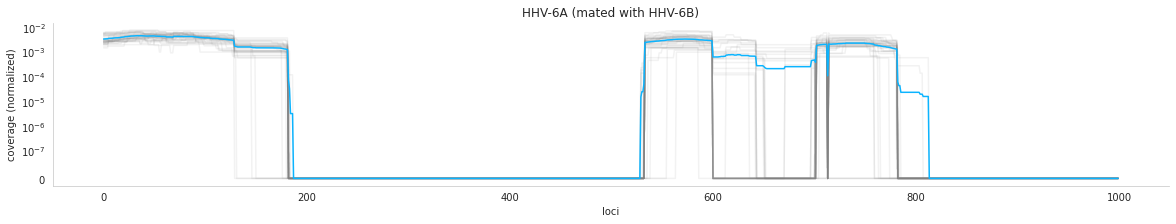

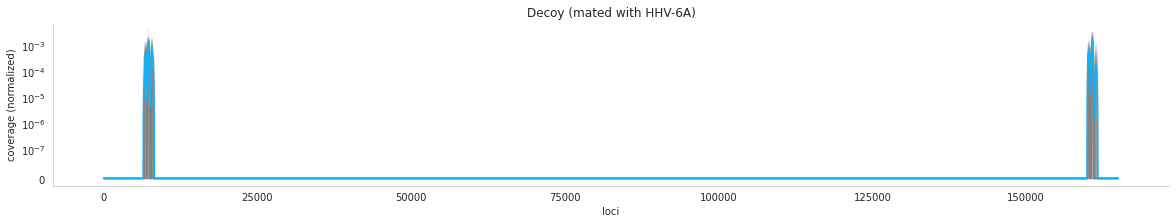

In [87]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, infected_hhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, infected_hhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infected_hhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


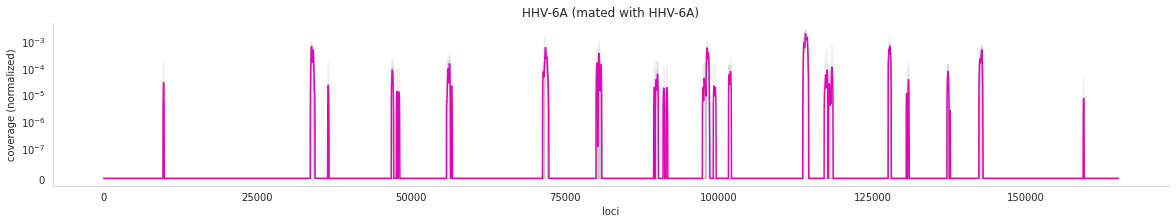

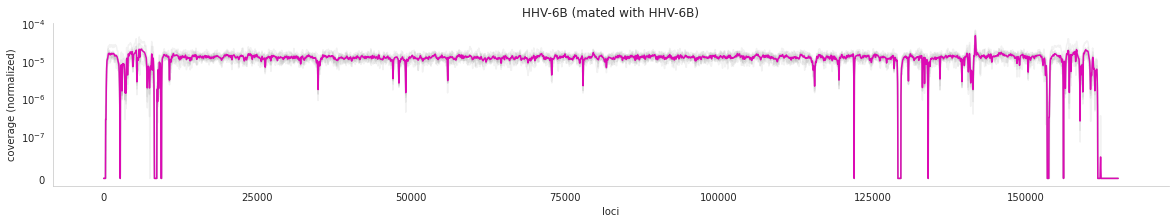

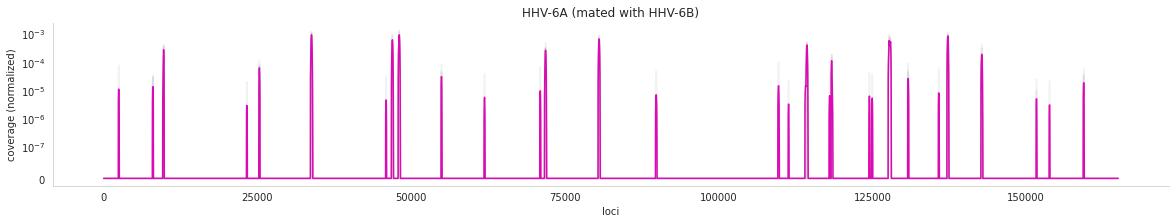

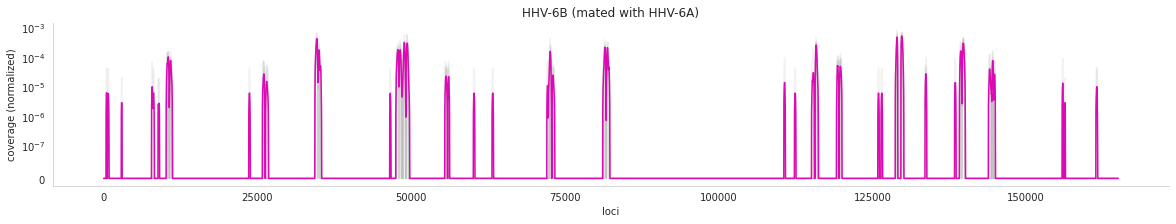

In [67]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, LCL_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, LCL_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, LCL_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


# Decoy Contig Seq

In [420]:
decoy_seq = [r for r in SeqIO.read(
    '/home/groups/dpwall/briannac/general_data/reference_genomes/GRCh38_reference_genome/' + 
    'GRCh38_full_analysis_set_plus_decoy_hla.fa', 'fasta') if
 r.id=='chrUn_JTFH01000690v1_decoy']



ValueError: More than one record found in handle

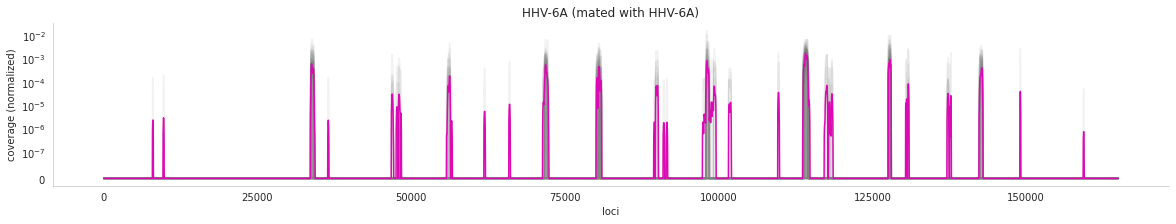

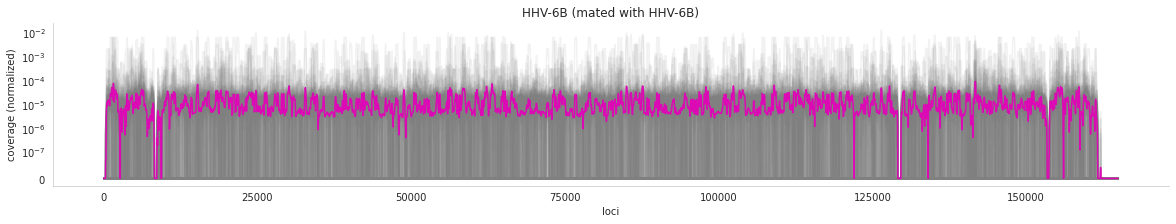

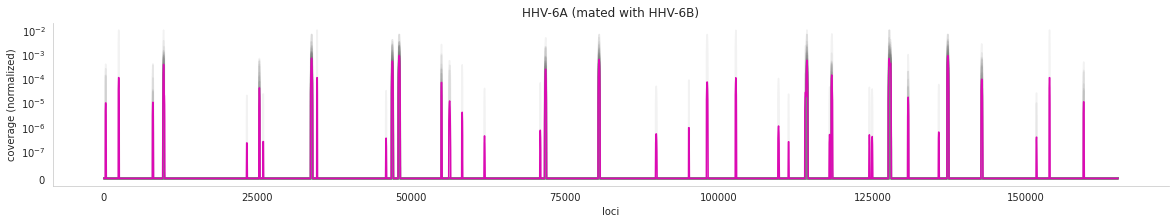

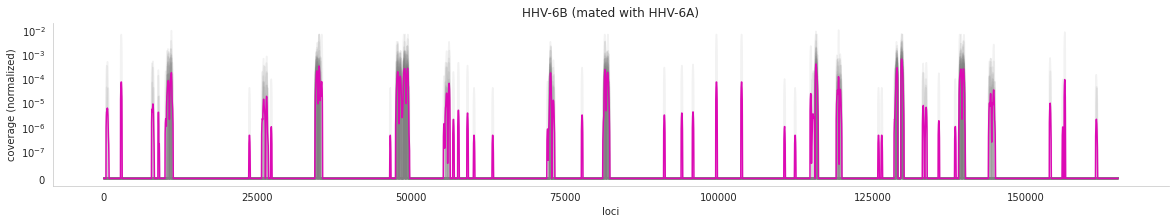

In [60]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6a_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


cov_sum1, cov_all1, cov_sum2, cov_all2  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all1):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum1[i]/len(cov_all1)) if i in cov_sum1 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all2):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum2[i]/len(cov_all2)) if i in cov_sum2 else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#dc0ab4')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


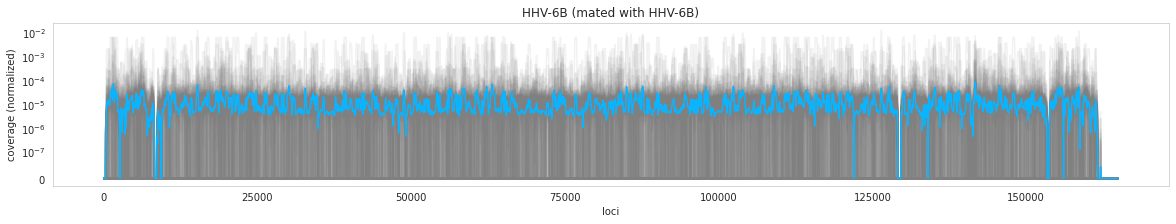

In [502]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#0bb4ff')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6B)')
plt.show()


#cov_sum, cov_all  = coverage_proper_pairs(herpes_6b_contig, list(h6b_med))

#f, ax = plt.subplots(figsize=(20,3))
#for idx, cov_i in enumerate(cov_all):
#    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
#    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
#loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
#plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
#plt.yscale('symlog', linthresh=1e-7)
#plt.xlabel('loci')
#plt.ylabel('coverage (normalized)')
#plt.title('HHV-6B (mated with HHV-6B)')
#plt.show()

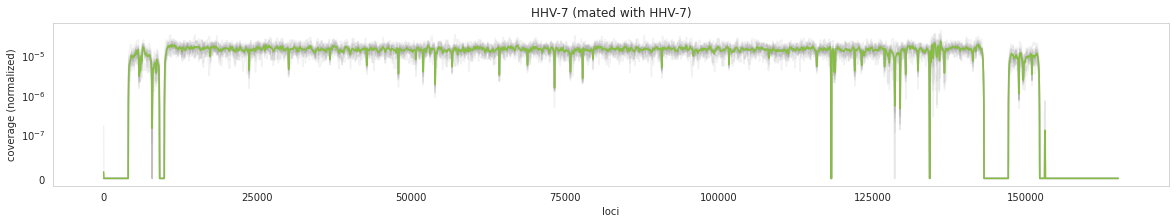

In [ ]:
cov_sum, cov_all  = coverage_proper_pairs(herpes_7_contig, h7_high)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#87bc45')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-7 (mated with HHV-7)')
plt.show()




cov_sum, cov_all  = coverage_proper_pairs(herpes_7_contig, h7_med)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov_sum[i]/len(cov_all)) if i in cov_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='#87bc45')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-7 (mated with HHV-7)')
plt.show()

# Paired With Different HHV

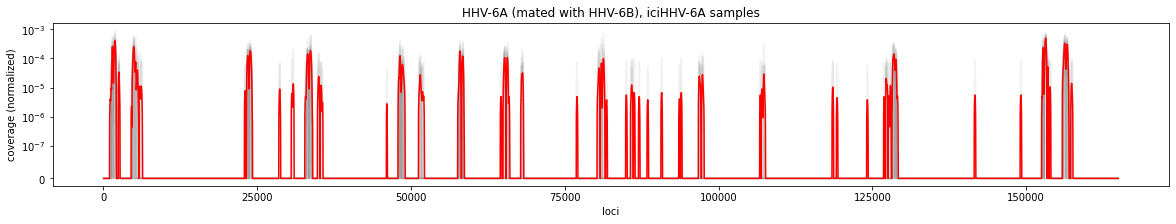

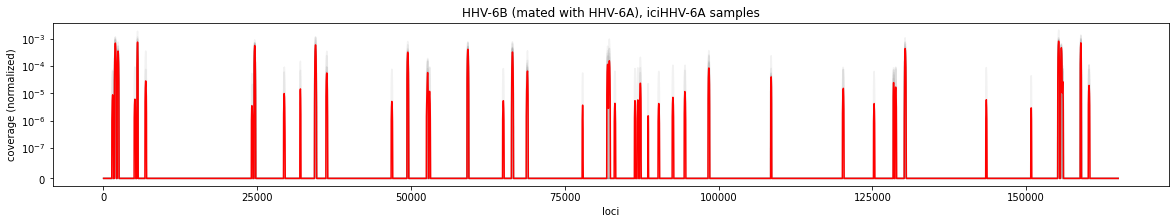

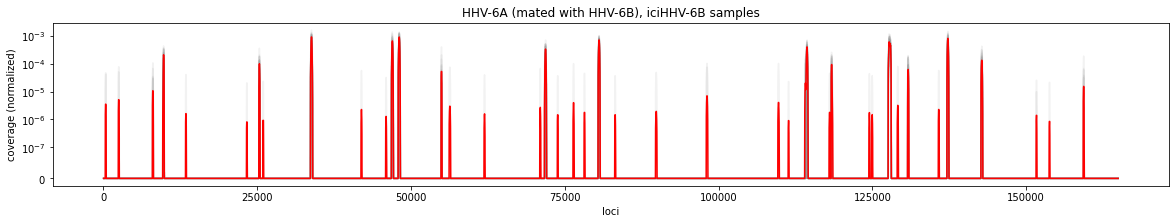

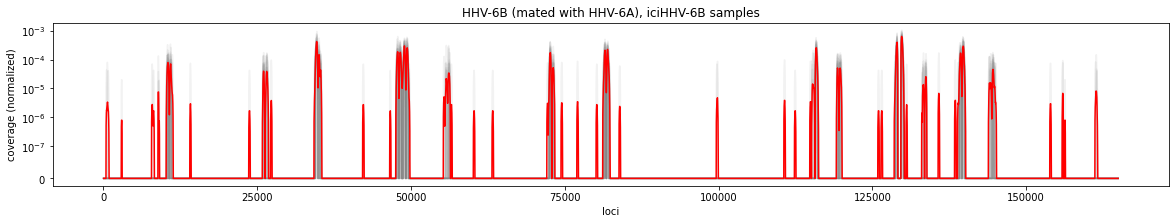

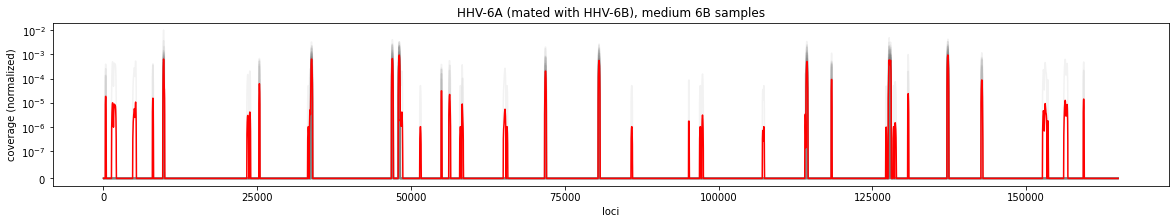

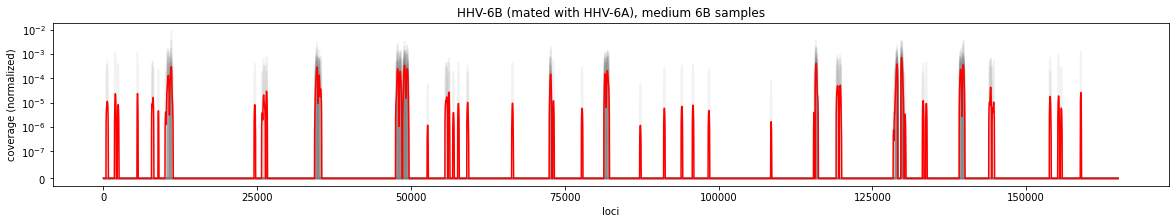

In [279]:
cov1_sum, cov1_all, cov2_sum, cov2_all  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, icihhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B), iciHHV-6A samples')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A), iciHHV-6A samples')
plt.show()






cov1_sum, cov1_all, cov2_sum, cov2_all  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infected_hhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B), iciHHV-6B samples')
plt.show()


#f, ax = plt.subplots(figsize=(20,3))
#for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A), iciHHV-6B samples')
plt.show()





cov1_sum, cov1_all, cov2_sum, cov2_all  = coverage_pairs_diff_contig(herpes_6a_contig, herpes_6b_contig, infe)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with HHV-6B), medium 6B samples')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), avg_window), moving_average(list(loci_cov_dict.values()), avg_window), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with HHV-6A), medium 6B samples')
plt.show()

# Paired with Decoy

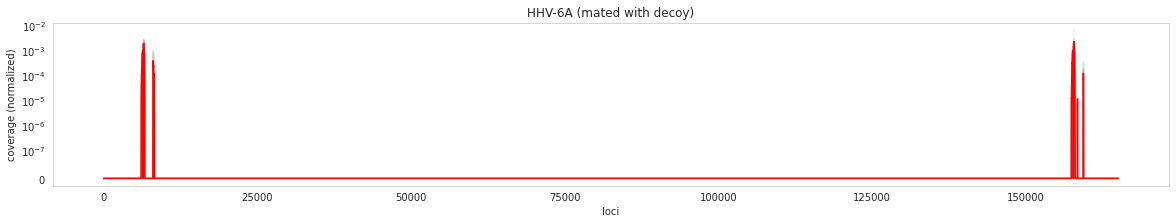

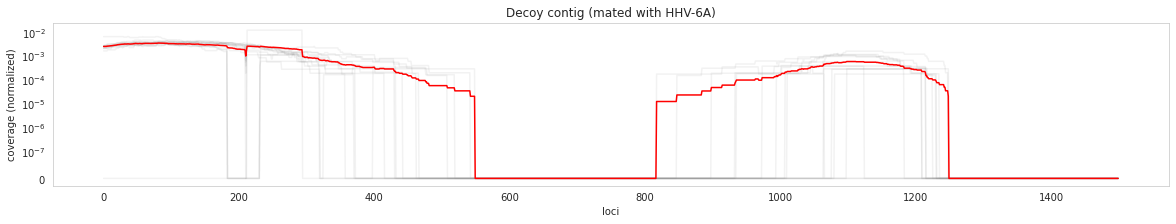

In [364]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6a_contig, icihhv_6a)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6A (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6A)')
plt.show()

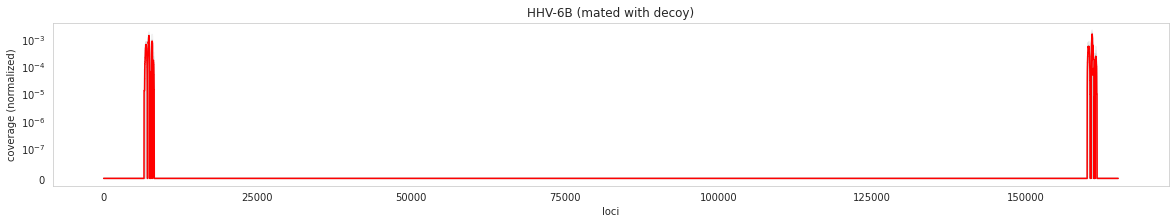

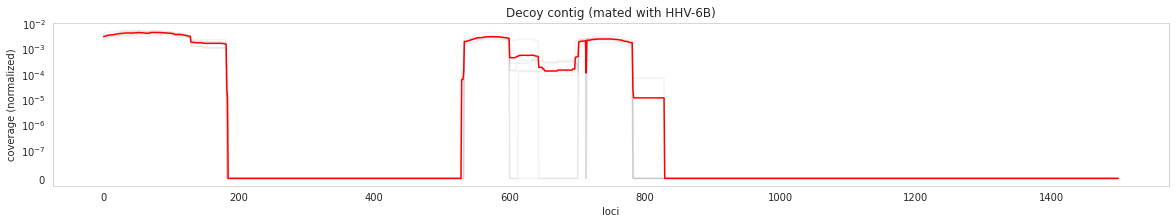

In [365]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, noninherited_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

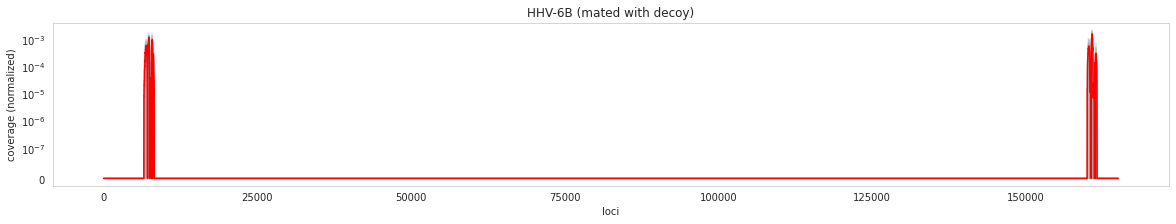

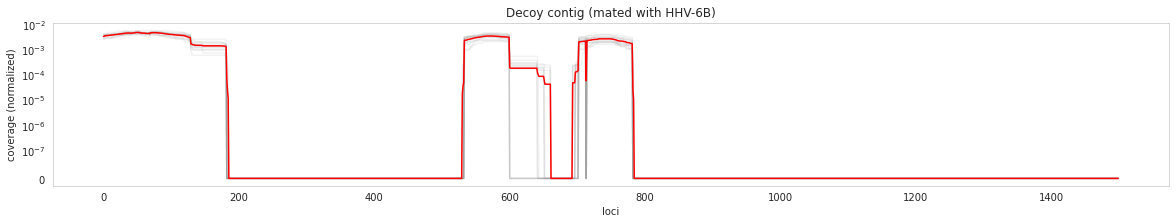

In [366]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, icihhv_6b)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

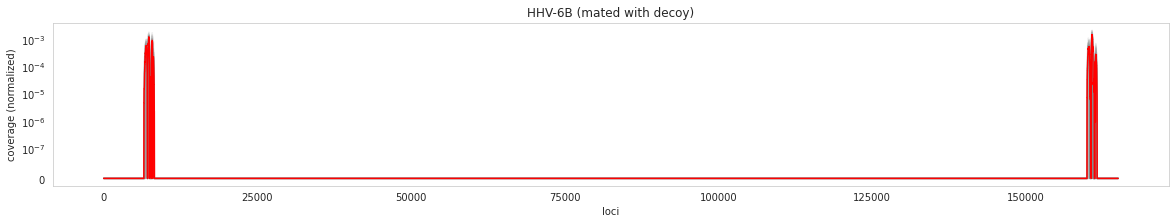

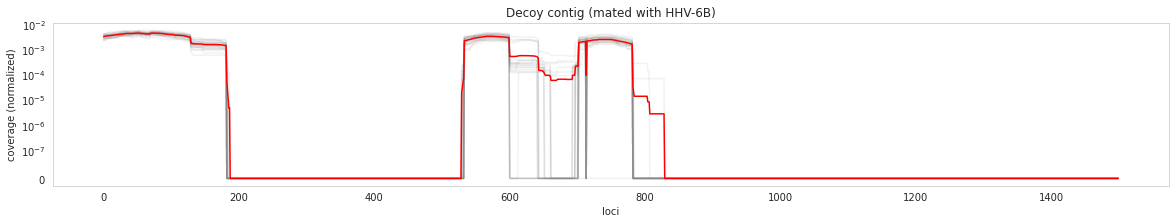

In [367]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, h6b_high)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

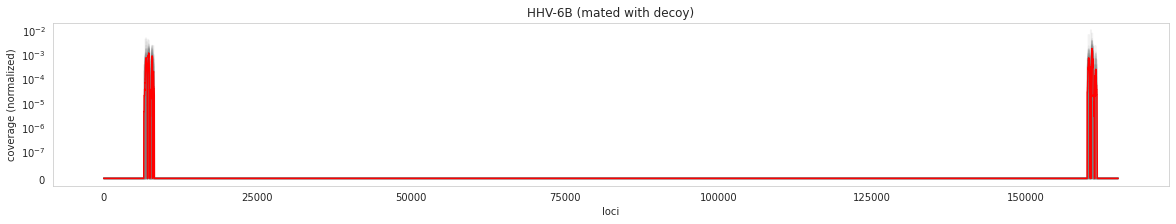

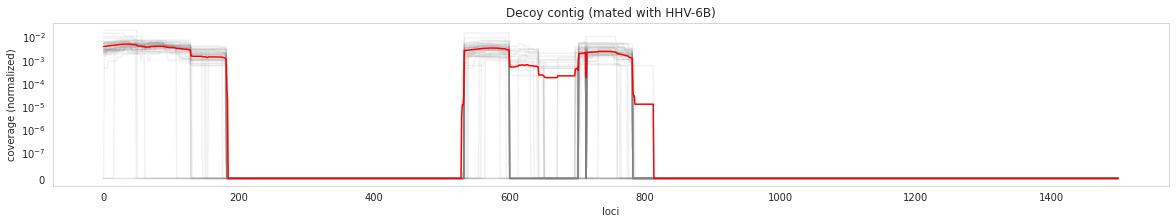

In [368]:
cov2_sum, cov2_all, cov1_sum, cov1_all  = coverage_pairs_diff_contig(decoy_contig, herpes_6b_contig, h6b_med)

f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov1_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(165000)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov1_sum[i]/len(cov1_all)) if i in cov1_sum else 0 for i in range(165000)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('HHV-6B (mated with decoy)')
plt.show()


f, ax = plt.subplots(figsize=(20,3))
for idx, cov_i in enumerate(cov2_all):
    loci_cov_dict = {i:cov_i[i] if i in cov_i else 0 for i in range(1500)}
    plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='grey', alpha=.1)
loci_cov_dict = {i:(cov2_sum[i]/len(cov2_all)) if i in cov2_sum else 0 for i in range(1500)}
plt.plot(moving_average(list(loci_cov_dict.keys()), 1), moving_average(list(loci_cov_dict.values()), 1), color='red')
plt.yscale('symlog', linthresh=1e-7)
plt.xlabel('loci')
plt.ylabel('coverage (normalized)')
plt.title('Decoy contig (mated with HHV-6B)')
plt.show()

# Double Checking sequencing plate

In [1]:
import pandas as pd
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

from tqdm import tqdm
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.feature_selection import f_regression
from sklearn import metrics
colors = ["#8687d1", "#ff9900",  "#3b5c36"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
F_REGRESSION_RESULTS = BLOOD_MICROBIOME_DIR + 'results/f_regression/f_regression_results.csv'
BAM_MAPPINGS_FILE = BLOOD_MICROBIOME_DIR + 'data/bam_mappings.csv'
bam_mappings = pd.read_csv(BAM_MAPPINGS_FILE, sep='\t', index_col=1)


In [2]:
f_regress_results = pd.read_csv(F_REGRESSION_RESULTS, header=None)
f_regress_results.drop(0, inplace=True, axis=1)
f_regress_results.columns = ['name', 'exog_value', 'coeff']
f_regress_results['coeff_abs'] = abs(f_regress_results.coeff)

In [14]:
f_regress_results[f_regress_results.name=='Human betaherpesvirus 7']

,name,exog_value,coeff,coeff_abs
25315,Human betaherpesvirus 7,family_AU1309,0.166483,0.166483
25316,Human betaherpesvirus 7,family_AU1923,0.012934,0.012934
25317,Human betaherpesvirus 7,family_AU1886,0.153723,0.153723
25318,Human betaherpesvirus 7,family_AU1604,0.162528,0.162528
25319,Human betaherpesvirus 7,family_AU1510,0.140498,0.140498
25320,Human betaherpesvirus 7,bio_seq_source_WB,0.044437,0.044437
25321,Human betaherpesvirus 7,family_AU1043,0.049330,0.049330
25322,Human betaherpesvirus 7,family_AU3849,0.027649,0.027649
25323,Human betaherpesvirus 7,family_AU3792,0.025736,0.025736
25324,Human betaherpesvirus 7,family_AU1749,0.029922,0.029922


# Whole blood vs LCL on same samples

In [14]:
# HHV-6A

In [63]:
LCL_samples = [(b, b.replace('_LCL', '')) for b in bam_mappings.index if '_' in str(b)]
dup_samples = [(i,j) for i,j in LCL_samples if (i in df_virus.index) and (j in df_virus.index)]
LCL_samples = [i for i,_ in dup_samples]
WB_samples = [j for _,j in dup_samples]


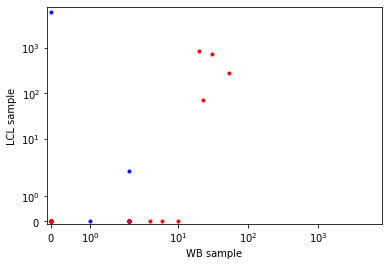

In [72]:
plt.plot(df_virus.loc[WB_samples]['Human betaherpesvirus 6B'].values, df_virus.loc[LCL_samples]['Human betaherpesvirus 6B'].values, '.', color='blue')
plt.plot(df_virus.loc[WB_samples]['Human betaherpesvirus 7'].values, df_virus.loc[LCL_samples]['Human betaherpesvirus 7'].values, '.', color='red')

plt.xlabel('WB sample')
plt.ylabel('LCL sample')
plt.xlim(-.1,8000)
plt.ylim(-.1,8000)
plt.xscale('symlog')
plt.yscale('symlog')
plt.show('HHV-6B')


In [178]:
pairings_melt = pairings_df.melt()

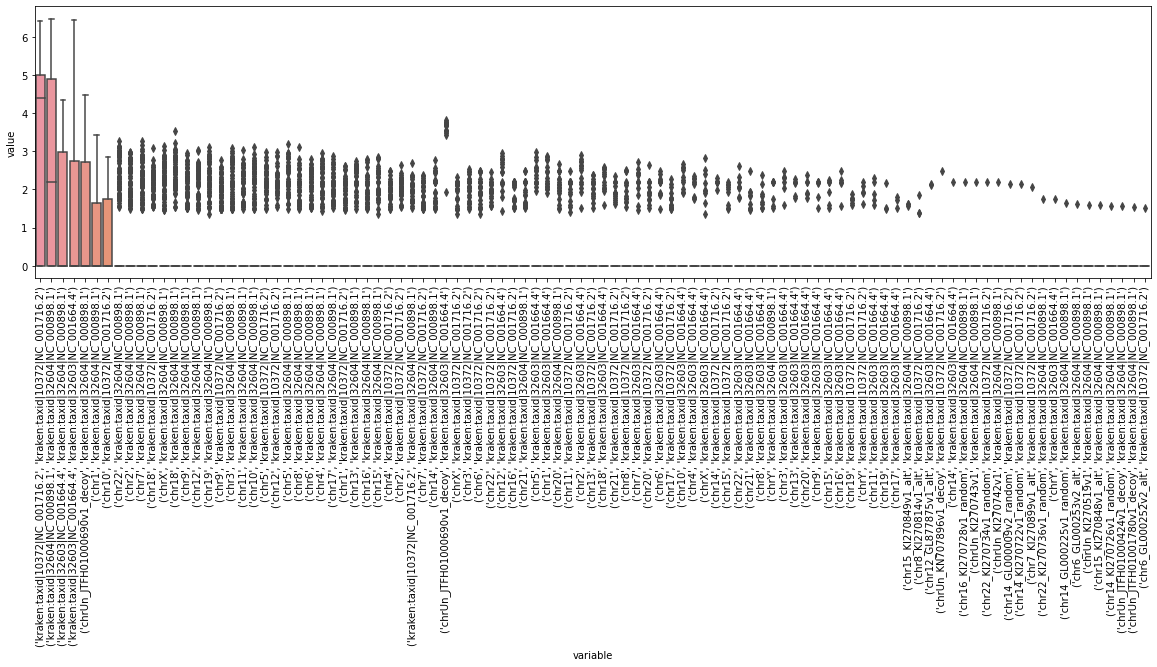

In [179]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=pairings_melt,x='variable', y='value')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
#plt.yscale('symlog')
plt.show()

In [ ]:
def PrepCounterForPlot(coverage_counts):
    loci = np.array([int(i) for i in list(coverage_counts.keys())])
    counts = np.array([int(i) for i in list(coverage_counts.values())])
    counts = counts[np.argsort(loci)]
    loci = sorted(loci)
    #loci_set = set(loci)
    avg_counts = np.zeros(int(max(loci))-int(min(loci)))
    avg_counts[loci-min(loci)-1]  = list(counts)
    loci = np.array([i for i in range(min(loci), max(loci))])
    return pd.Series(loci).rolling(window=1000).mean(), pd.Series(avg_counts).rolling(window=1000).mean() # Return rolling average for cleaner plots.

In [331]:
pair = pairings_df.columns[0]
samples = set(h6a_high).intersection(coverages_dict.keys())
covs_1 = [coverages_dict[k][pair][0] for k in samples if pair in coverages_dict[k]]
covs_2 = [coverages_dict[k][pair][1] for k in samples if pair in coverages_dict[k]]

In [335]:
herpes_6b_contig

'kraken:taxid|32604|NC_000898.1'

In [311]:
selected_cov=covs_1
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()

selected_cov=covs_2
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()


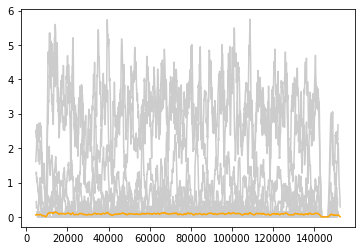

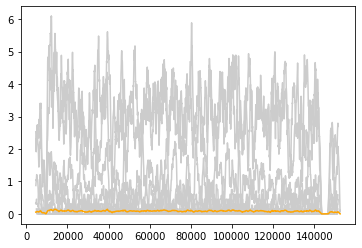

In [312]:
selected_cov=covs_1
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()

selected_cov=covs_2
for covs in selected_cov:
    loci, avg_counts = PrepCounterForPlot(covs)
    plt.plot(loci, avg_counts, color=(.8,.8,.8))
counter_sum = sum(selected_cov, Counter())
loci, avg_counts = PrepCounterForPlot(counter_sum)
plt.plot(loci, avg_counts/len(selected_cov), 'orange')
plt.show()



In [195]:
counter_sum = sum(covs_1[:100], Counter())

In [221]:
np.array(list(counter_sum.values()))[np.argsort(list(counter_sum.keys()))]

array([4, 4, 4, ..., 1, 1, 1])

In [218]:
len(np.argsort(list(counter_sum.keys())))

140387

In [226]:
max(loci)

153058.0

In [266]:
loci = np.array([int(i) for i in list(counter_sum.keys())])
counts = np.array([int(i) for i in list(counter_sum.values())])
counts = counts[np.argsort(loci)]
loci = sorted(loci)
#loci_set = set(loci)
avg_counts = np.zeros(int(max(loci))-int(min(loci)))
avg_counts[loci-min(loci)-1]  = list(counts)
loci = np.array([i for i in range(min(loci), max(loci))])
#list(counter_sum.values()))[np.argsort(list(counter_sum.keys()))]
#plt.plot([l for l in range(int(min(loci)), int(max(loci)))], [avg_counts[i] if l in loci_set else 0 for i,l in enumerate(range(int(min(loci)), int(max(loci))))], '-')

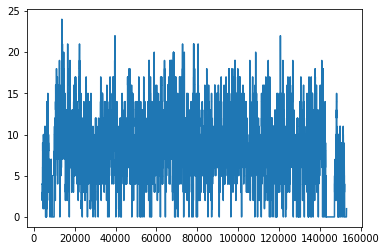

In [270]:
plt.plot(loci, avg_counts)

In [30]:

pair = ('kraken:taxid|10372|NC_001716.2', 'kraken:taxid|10372|NC_001716.2')

coverages_dict[k][pair][0].keys()

dict_keys([113797, 113798, 113799, 113800, 113801, 113802, 113803, 113804, 113805, 113806, 113807, 113808, 113809, 113810, 113811, 113812, 113813, 113814, 113815, 113816, 113817, 113818, 113819, 113820, 113821, 113822, 113823, 113824, 113825, 113826, 113827, 113828, 113829, 113830, 113831, 113832, 113833, 113834, 113835, 113836, 113837, 113838, 113839, 113840, 113841, 113842, 113843, 113844, 113845, 113846, 113847, 113848, 113849, 113850, 113851, 113852, 113853, 113854, 113855, 113856, 113857, 113858, 113859, 113860, 113861, 113862, 113863, 113864, 113865, 113866, 113867, 113868, 113869, 113870, 113871, 113872, 113873, 113874, 113875, 113876, 113877, 113878, 113879, 113880, 113881, 113882, 113883, 113884, 113885, 113886, 113887, 113888, 113889, 113890, 113891, 113892, 113893, 113894, 113895, 113896, 113897, 113898, 113899, 113900, 113901, 113902, 113903, 113904, 113905, 113906, 113907, 113908, 113909, 113910, 113911, 113912, 113913, 113914, 113915, 113916, 113917, 113918, 113919, 11392

In [2]:
df_virus = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/df_virus_filtered.csv', index_col=0)
df_virus.index = [i.split(' -')[0] for i in df_virus.index]
bam_mappings = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/data/bam_mappings.csv', sep='\t', index_col=1)

In [70]:
def saveHighResFig(fig_name):
    plt.tight_layout()
    plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/%s.png' % fig_name, 
                transparent=True, bbox_inches='tight', format='png', dpi=500)

In [62]:
def GetCoverage(sample, contig_names, save_file):
    batch = bam_mappings.loc[sample].get('sequencing_plate').replace('MTR-', '')
    decoy_contig = 'chrUn_JTFH01000690v1_decoy'

    # Extract reads    
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        proper_reads = [r  for c in contig_names for r in samfile.fetch(c) if (~r.is_supplementary & ~r.is_secondary)]
    #with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample, sample), "r") as samfile:
    #    improper_reads = [r  for c in contig_names for r in samfile.fetch(c) if (~r.is_proper_pair & ~r.is_supplementary & ~r.is_secondary)]
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.paired.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        mated_with_unmapped_reads = [r  for c in contig_names for r in samfile.fetch(c) if (r.mate_is_unmapped & ~r.is_supplementary & ~r.is_secondary)]
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.single.aln_all.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        mated_with_ref_genome_dict = {r.query_name:r for c in contig_names for r in samfile.fetch(c) if (~r.is_supplementary & ~r.is_secondary)}
    with  pysam.AlignmentFile("s3://ihart-ms2/unmapped/batch_%s/%s/%s.final.map_unmap.bam" % (batch, sample.replace('_','-'), sample.replace('_','-')), "r") as samfile:
        decoy_dict = {r.query_name:r for r in samfile.fetch(decoy_contig)}
    
    # Compute coverage
    decoy_pair_keys = set(decoy_dict.keys()).intersection(set(mated_with_ref_genome_dict.keys()))
    decoy_reads = [decoy_dict[i] for i in decoy_pair_keys]
    mated_with_decoy_reads = [mated_with_ref_genome_dict[i] for i in decoy_pair_keys]
    
    proper_pair_ids = Counter([p.query_name for p in proper_reads])
    proper_reads_same_chrom = [p for p in proper_reads if proper_pair_ids[p.query_name]==2]
        
    if len(proper_reads)>0: proper_coverage = np.concatenate([r.get_reference_positions() for r in proper_reads])
    else: proper_coverage = []
    #if len(improper_reads)>0: improper_coverage = np.concatenate([r.get_reference_positions() for r in improper_reads])
    #else: improper_coverage = []
    if len(mated_with_decoy_reads)>0: mated_with_decoy_coverage = np.concatenate([r.get_reference_positions() for r in mated_with_decoy_reads])
    else: mated_with_decoy_coverage = []
    if len(mated_with_unmapped_reads)>0:  mated_with_unmapped_coverage = np.concatenate([r.get_reference_positions() for r in mated_with_unmapped_reads])
    else: mated_with_unmapped_coverage = []
    if len(decoy_reads)>0: decoy_coverage = np.concatenate([r.get_reference_positions() for r in decoy_reads])
    else: decoy_coverage = []
    
    # Create and save dictionary.
    coverage_dict = dict()
    coverage_dict['proper_coverage'] = proper_coverage
    #coverage_dict['improper_coverage'] = improper_coverage
    coverage_dict['mated_with_decoy_coverage'] = mated_with_decoy_coverage
    coverage_dict['mated_with_unmapped_coverage'] = mated_with_unmapped_coverage
    coverage_dict['decoy_coverage'] = decoy_coverage
    np.save(save_file, coverage_dict)
    for f in glob.glob('%s.*.bai' % sample):
        os.remove(f)
    return coverage_dict
    
    

def CoverageHistograms(coverage_dicts, bins_virus, bins_decoy):
    f, ax = plt.subplots(ncols=4,figsize=(25,3))
    n_avg_paired = np.zeros(len(bins_virus)-1)
    #n_avg_improper = np.zeros(len(bins_virus)-1)
    n_avg_paired_with_unmapped = np.zeros(len(bins_virus)-1)
    n_avg_paired_with_decoy = np.zeros(len(bins_virus)-1)
    n_avg_decoy_seq = np.zeros(len(bins_decoy)-1)

    for s in coverage_dicts.keys():
        
        # Virus-Virus coverage:
        n,_ = np.histogram(coverage_dicts[s]['proper_coverage'], bins=bins_virus)
        n_avg_paired = n_avg_paired + n/sum(n)
        ax[0].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)
        
        # Virus-Virus coverage:
        #n,_ = np.histogram(coverage_dicts[s]['improper_coverage'], bins=bins_virus)
        #n_avg_improper = n_avg_improper + n/sum(n)
        #ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)

        # Virus-Unmapped coverage
        if len(coverage_dicts[s]['mated_with_unmapped_coverage'])>0:
            n,_ = np.histogram(coverage_dicts[s]['mated_with_unmapped_coverage'], bins=bins_virus)
            n_avg_paired_with_unmapped = n_avg_paired_with_unmapped + n/sum(n)
            ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)

        else:
            ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, 0*bins_virus[1:], color='grey', alpha=.3)

        # Virus-decoy pairs
        if len(coverage_dicts[s]['mated_with_decoy_coverage'])>0:
            n,_ = np.histogram(coverage_dicts[s]['mated_with_decoy_coverage'], bins=bins_virus)
            n_avg_paired_with_decoy = n_avg_paired_with_decoy + n/sum(n)
            ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, n/sum(n), color='grey', alpha=.5)
            
            n,_ = np.histogram(coverage_dicts[s]['decoy_coverage'], bins=bins_decoy)
            n_avg_decoy_seq = n_avg_decoy_seq + n/sum(n)
            ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, n/sum(n), color='grey', alpha=.5)

        else:
            ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, 0*bins_virus[1:], color='grey', alpha=.3)
            ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, 0*bins_decoy[1:], color='grey', alpha=.5)
            
            
    ax[0].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired/len(coverage_dicts), color='orange', alpha=1)
    ax[1].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired_with_unmapped/len(coverage_dicts), color='orange', alpha=1)
    ax[2].plot((bins_virus[1:]+bins_virus[:-1])/2, n_avg_paired_with_decoy/len(coverage_dicts), color='orange', alpha=1)
    ax[3].plot((bins_decoy[1:]+bins_decoy[:-1])/2, n_avg_decoy_seq/len(coverage_dicts), color='orange', alpha=1)

    for i in range(4):
        ax[i].set_yticks([])
        ax[i].set(frame_on=False)
        ax[i].locator_params(nbins=5)

In [105]:
df_virus = df_virus[['Human herpesvirus 6A', 'Human herpesvirus 6B', 'Human herpesvirus 7', 'type','family']]

In [64]:
herpes_7_contigs = {'AF037218.1','KF558370.1', 'MH507176.1','MH507177.1','MK619207.1','MT314265.1','MT314266.1','MT314267.1','MT314268.1',
                    'MT314269.1','NC_001716.2','VIRL|gi|51874225|ref|NC_001716.2|'}
herpes_6A_contigs =  {'JX152762.1','KC465951.1','KP026965.1','KP257584.1','KT355575.1','KY316047.1','KY316048.1',
                      'KY316049.1','KY316054.1','KY316055.1','KY316056.1','MF994813.1','MF994815.1','MF994816.1',
                      'MF994817.1','MF994818.1','MF994819.1','MF994820.1','MF994822.1','MF994828.1','MH698400.1',
                      'MH698403.1','MK630133.1','MK630134.1','MN079022.1','MN079023.1','MN079024.1','NC_001664.4',
                      'U04437.1','U13194.1','U23467.1','VIRL|gi|224020395|ref|NC_001664.2|','X83413.2'}
herpes_6B_contigs = {'EU861010.1','EU861011.1','EU861012.1','EU861013.1','EU861014.1','EU861015.1','EU861016.1','EU861017.1','EU861018.1',
                     'EU861019.1','EU861020.1','EU861021.1','EU861022.1','EU861023.1','EU861024.1','EU861025.1','EU861026.1','EU861027.1',
                     'EU861028.1','FJ610376.1','FJ610377.1','FJ610378.1','FJ610379.1','FJ610380.1','FJ610381.1','FJ610382.1','FJ610383.1',
                     'FJ610384.1','FJ610385.1','FJ610386.1','FJ610387.1','FJ610388.1','FJ610389.1','FJ610390.1','FJ610391.1','FJ610392.1',
                     'FJ610393.1','FJ610394.1','FJ610395.1','FJ610396.1','FJ610397.1','FJ610398.1','FJ610399.1','FJ610400.1','FJ610401.1',
                     'FJ610402.1','FJ610403.1','FJ610404.1','FJ610405.1','FJ610406.1','FJ610407.1','FJ610408.1','FJ610409.1','FJ610410.1',
                     'FJ610411.1','FJ610412.1','FJ610413.1','FJ610414.1','FJ610415.1','FJ610416.1','FJ610417.1','FJ610418.1','FJ610419.1',
                     'FJ610420.1','FJ610421.1','FJ610422.1','FJ610423.1','FJ610424.1','FJ610425.1','FJ610426.1','FJ610427.1','FJ610428.1',
                     'FJ610429.1','FJ610430.1','FJ610431.1','FJ610432.1','FJ610433.1','FJ610434.1','FJ610435.1','FJ610436.1','FJ610437.1',
                     'FJ610438.1','JX235339.1','KF130944.1','KF130945.1','KF130946.1','KF130947.1','KX595170.1','KY316030.1','KY316031.1',
                     'KY316032.1','KY316033.1','KY316034.1','KY316035.1','KY316036.1','KY316037.1','KY316038.1','KY316039.1','KY316040.1',
                     'KY316041.1','KY316042.1','KY316043.1','KY316044.1','KY316045.1','KY316046.1','KY316050.1','KY316051.1','KY316052.1',
                     'KY316053.1','MF624253.1','MF624254.1','MF624255.1','MF624256.1','MF624257.1','MF624258.1','MF624259.1','MF624260.1',
                     'MF624261.1','MF624262.1','MF624263.1','MF994814.1','MF994821.1','MF994823.1','MF994824.1','MF994825.1','MF994826.1',
                     'MF994827.1','MF994829.1','MH507178.1','MH698398.1','MH698399.1','MH698401.1','MH698402.1','MK388090.1','MK629887.1',
                     'MK629888.1','MK629889.1','MK629890.1','MK629891.1','MK629892.1','MK629893.1','MK629894.1','MK629895.1','MK629896.1',
                     'MK629897.1','MK629898.1','MK629899.1','MK629900.1','MK629901.1','MK629902.1','MK629903.1','MK629904.1','MK629905.1',
                     'MK629906.1','MK629907.1','MK629908.1','MK629909.1','MK629910.1','MK629911.1','MK629912.1','MK629913.1','MK629914.1',
                     'MK629915.1','MK629916.1','MK629917.1','MK629918.1','MK629919.1','MK629920.1','MK629921.1','MK629922.1','MK629923.1',
                     'MK629924.1','MK629925.1','MK629926.1','MK629927.1','MK629928.1','MK629929.1','MK629930.1','MK629931.1','MK629932.1',
                     'MK629933.1','MK629934.1','MK629935.1','MN242397.1','NC_000898.1', 'VIRL|gi|9633069|ref|NC_000898.1|'}


# General Abundances

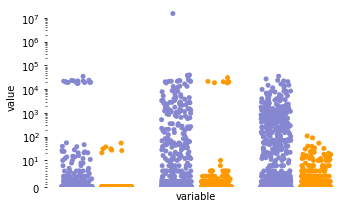

In [108]:
df_melt = df_virus.melt(id_vars=['type','family'])
plt.figure(figsize=(5,3))
sns.stripplot(data=df_melt, y='value', x='variable', hue='type',jitter=.3,palette=['#ff9900', '#8687d1'], dodge=True)
plt.yscale("symlog", linthresh=10)
plt.ylim(0,df_melt['value'].max().max()*2)
yaxis = plt.gca().yaxis
plt.legend().remove()
plt.xticks([])
yaxis.set_minor_locator(MinorSymLogLocator(10))
plt.tight_layout()
plt.box(on=None)
saveHighResFig('herpes_abundances_vs_cell_type')
plt.show()

In [129]:
Counter([(i,j) for i,j in zip(df_virus['Human herpesvirus 6B']>1000, bam_mappings.loc[df_virus.index].relationship=='sibling')])

Counter({(False, True): 2625,
         (False, False): 1869,
         (True, False): 20,
         (True, True): 54})

In [122]:
288/1798

0.16017797552836485

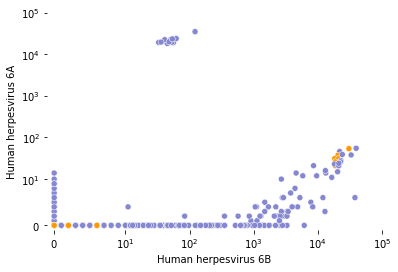

In [111]:
sns.scatterplot(data=df_virus, y='Human herpesvirus 6A', x='Human herpesvirus 6B', hue='type',palette=['#8687d1', '#ff9900'])
plt.xscale("symlog", linthresh=10)
plt.yscale("symlog", linthresh=10)
plt.ylim(-1,10**5)
plt.xlim(-1,10**5)
plt.box(on=None)

plt.legend().remove()
plt.show()

^ Note that the cluster of WB 6A around ~10 look like they are actually reads coming from H6B.

# Herpesvirus 6A
This should be pretty straightforward. Very clear cluster at expected abundance levels of germline integration of 6A.

In [3]:
bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6A']>1000].sort_values('family').index].bio_seq_source

03C16028    LCL
03C16815    LCL
03C16818    LCL
02C11465    LCL
03C16621    LCL
03C16623    LCL
04C37990    LCL
03C16632    LCL
03C16633    LCL
03C16634    LCL
06C54349    LCL
06C54347    LCL
06C54351    LCL
06C53148    LCL
06C53149    LCL
06C53151    LCL
Name: bio_seq_source, dtype: object

^ Except for one weird sample, no evidence of de novo integration. No children showed germline integration without parents.

**03C16028** -- this is the weird sample that looks like de novo herpes 6A AND de novo herpes 6B germline, and has a TON of herpes 6B

In [506]:
print(df_virus['Human herpesvirus 6A'].loc[bam_mappings[bam_mappings.family=='AU0164'].index])
bam_mappings[bam_mappings.family=='AU0164']

sample_id
03C16026       0.0
03C16027       2.0
03C16028    8945.0
03C16639       1.0
Name: Human herpesvirus 6A, dtype: float64


,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
sample_id,,,,,,,,,,,,,,,,,,,,,
03C16026,Passed_QC_analysis_ready,AU016401,AU0164,HI0436,03C16026,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16027,Passed_QC_analysis_ready,AU016403,AU0164,HI0437,03C16027,sibling,AU016402,AU016401,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16028,Passed_QC_analysis_ready,AU016404,AU0164,HI0442,03C16028,sibling,AU016402,AU016401,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16639,Passed_QC_analysis_ready,AU016402,AU0164,HI2210,03C16639,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Herpes 6A -- Germline integration.

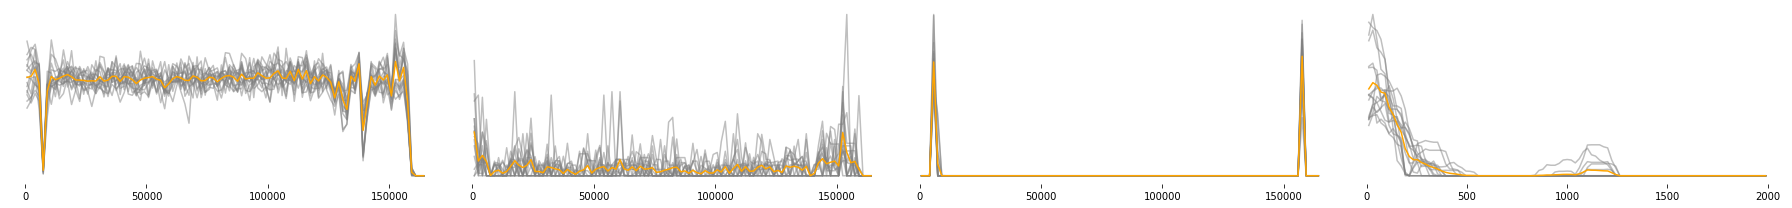

In [72]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6A_'
contig_names = {'VIRL|gi|224020395|ref|NC_001664.2|','NC_001664.4'}
    
coverage_dicts = dict()
for sample in bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6A']>1000].sort_values('family').index].iloc[1:].index:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_high')
plt.show()

## Herpes 6A -- Sample 03C16028.

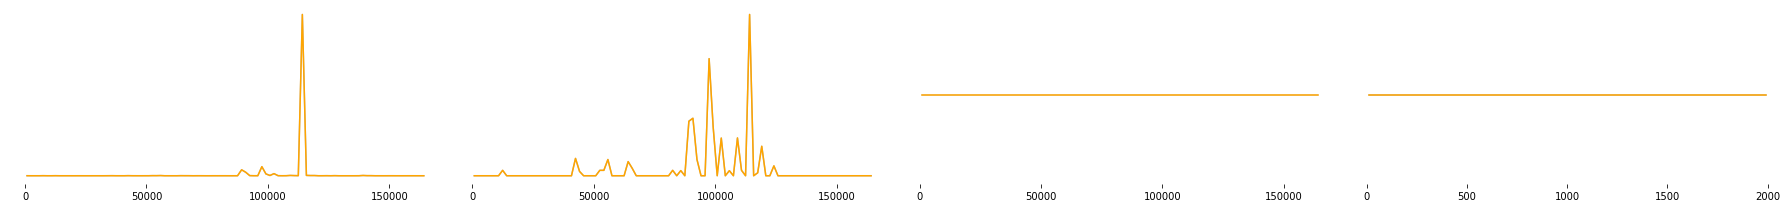

In [74]:
# Read in the weird sample for later use.
coverage_dicts = dict()
sample='03C16028'
filename = coverage_dir + sample + '.npy'
try: coverage_didcts[sample] = np.load(filename, allow_pickle=True).item()
except:
    coverage_dicts[sample] = GetCoverage(sample, {'VIRL|gi|224020395|ref|NC_001664.2|','NC_001664.4'}, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_03C16028')

## Herpes 6A -- No integration

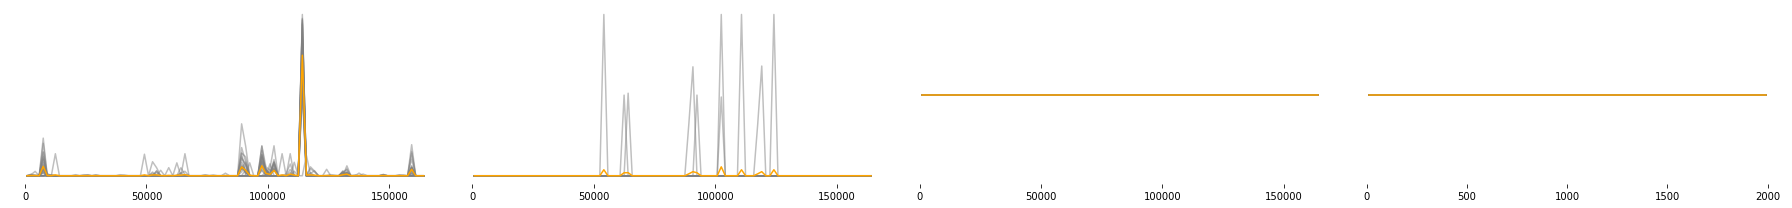

In [73]:
coverage_dicts = dict()
for sample in df_virus[(df_virus['Human herpesvirus 6A']<1000) & (df_virus['Human herpesvirus 6A']>10)].sort_values('family').index:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        print('retrieving sample ', sample)
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6A_low')
plt.show()

No handles with labels found to put in legend.


<Figure size 720x720 with 0 Axes>

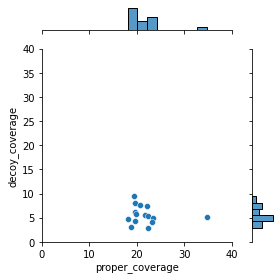

In [75]:
herpes_6A = df_virus[(df_virus['Human herpesvirus 6A']>1000)].index
coverage_dicts = dict()
for sample in herpes_6A:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

samples = list(coverage_dicts.keys())
decoy_coverage = np.array([len(coverage_dicts[c]['decoy_coverage'])/len(np.unique(coverage_dicts[c]['decoy_coverage'])) for c in coverage_dicts])
mated_w_decoy_coverage = np.array([len(coverage_dicts[c]['mated_with_decoy_coverage'])/len(np.unique(coverage_dicts[c]['mated_with_decoy_coverage'])) for c in coverage_dicts])
proper_coverage = np.array([len(coverage_dicts[c]['proper_coverage'])/160000 for c in coverage_dicts])
mated_with_unmapped_coverage = np.array([len(coverage_dicts[c]['mated_with_unmapped_coverage'])/len(np.unique(coverage_dicts[c]['mated_with_unmapped_coverage'])) for c in coverage_dicts])
df = pd.DataFrame([decoy_coverage, mated_w_decoy_coverage, proper_coverage, mated_with_unmapped_coverage]).transpose()
df.columns = ['decoy_coverage', 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']


for x in ['proper_coverage']:#, 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']:
    for y in ['decoy_coverage']:#, 'mated_w_decoy_coverage', '', 'mated_with_unmapped_coverage']:
        if x<=y: continue
        plt.figure(figsize=(10,10))
        g=sns.jointplot(data=df, x=x, y=y, palette=['#8687d1', '#3b5c36'], height=4)
        g.ax_joint.legend().remove()
        g.ax_marg_x.set_xlim(0, 40)
        g.ax_marg_y.set_ylim(0, 40)
        plt.xlabel('total reads ratio')
        plt.ylabel('decoy:virus ratio')
        plt.tight_layout()
        plt.show()
#plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_6A_total_vs_decoy.png', transparent=True, bbox_inches='tight', format='png', dpi=500)


# Herpes 6B

## Herpes 6B -- Highly suspected ancient integration

At least 2 family members have > 10000 reads.

In [6]:
herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
herpes_6B_high[[f in list(fams[fams.status>1].index) for f in herpes_6B_high.family]]

,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
04C27828,Passed_QC_analysis_ready,AU0412303,AU0412,HI3009,04C27828,sibling,AU0412201,AU0412202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04C27801,Passed_QC_analysis_ready,AU0412301,AU0412,HI2982,04C27801,sibling,AU0412201,AU0412202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04C27795,Passed_QC_analysis_ready,AU0412202,AU0412,HI2976,04C27795,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16635,Passed_QC_analysis_ready,AU080003,AU0800,HI2203,03C16635,sibling,AU080006,AU080001,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C16636,Passed_QC_analysis_ready,AU080001,AU0800,HI2205,03C16636,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05C49694,Passed_QC_analysis_ready,AU1589301,AU1589,HI4648,05C49694,sibling,AU1589201,AU1589202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05C49695,Passed_QC_analysis_ready,AU1589302,AU1589,HI4649,05C49695,sibling,AU1589201,AU1589202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05C49696,Passed_QC_analysis_ready,AU1589201,AU1589,HI4650,05C49696,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10C105333,Passed_QC_analysis_ready,AU2140305,AU2140,HI10221,10C105333,sibling,AU2140203,AU2140204,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10C105330,Passed_QC_analysis_ready,AU2140203,AU2140,HI10218,10C105330,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [281]:
df_virus.loc[herpes_6B_de_novo]['type']

03C15783    LCL
06C61448    LCL
07C66885    LCL
05C48098    LCL
09C90889    LCL
02C10855    LCL
Name: type, dtype: object

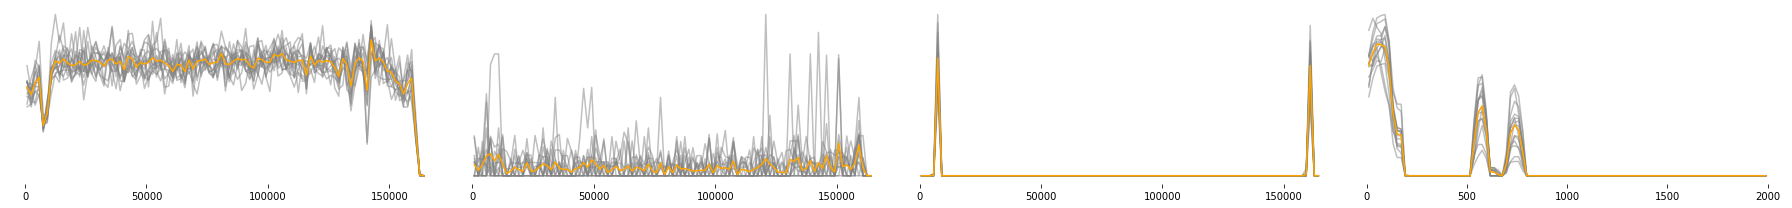

In [77]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6B_'
contig_names = {'VIRL|gi|9633069|ref|NC_000898.1|'}

herpes_6B_inherited = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_inherited.groupby('family').count()
herpes_6B_inherited = herpes_6B_inherited[[f in list(fams[fams.status>1].index) for f in herpes_6B_inherited.family]].index

coverage_dicts = dict()
for sample in herpes_6B_inherited:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_inherited')
plt.show()

In [24]:
print(Counter(df_virus.loc[herpes_6B_inherited]['type']))
print(Counter(df_virus['type']))

Counter({'LCL': 8, 'WB': 6})
Counter({'LCL': 3998, 'WB': 570})


## Herpes 6B -- possible de novo integration

In [42]:

herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 7']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
Counter(herpes_6B_high[[f in list(fams[fams.status>0].index) for f in herpes_6B_high.family]].bio_seq_source)
#Counter(bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index].bio_seq_source)

Counter({'LCL': 11})

In [41]:
fam='AU1965'
print(df_virus['Human herpesvirus 7'].loc[set(bam_mappings[bam_mappings.family==fam].index).intersection(set(df_virus.index))])
bam_mappings[bam_mappings.family==fam]

07C65014    23699.0
07C65017        0.0
07C65016        5.0
07C65015        0.0
Name: Human herpesvirus 7, dtype: float64


,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
sample_id,,,,,,,,,,,,,,,,,,,,,
07C65014,Passed_QC_analysis_ready,AU1965201,AU1965,HI5367,07C65014,father,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07C65015,Passed_QC_analysis_ready,AU1965202,AU1965,HI5368,07C65015,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07C65016,Passed_QC_analysis_ready,AU1965301,AU1965,HI5369,07C65016,sibling,AU1965201,AU1965202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07C65017,Passed_QC_analysis_ready,AU1965302,AU1965,HI5370,07C65017,sibling,AU1965201,AU1965202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


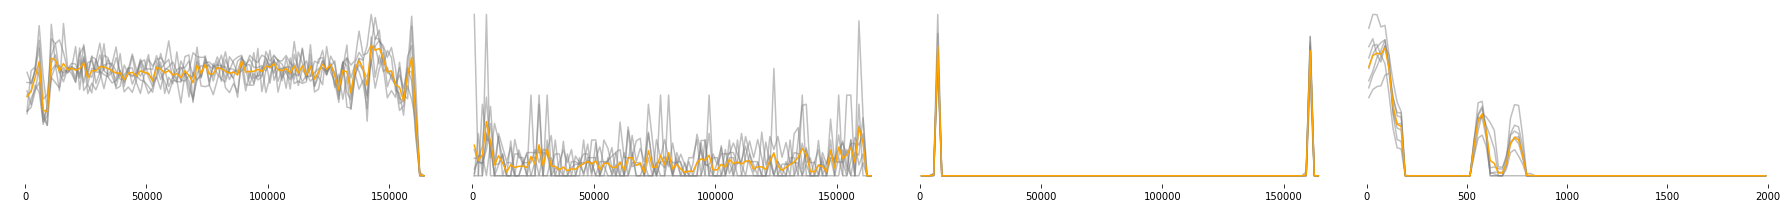

In [78]:
herpes_6B_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 6B']>10000].sort_values('family').index]
fams = herpes_6B_high.groupby('family').count()
herpes_6B_de_novo = ['03C15783','06C61448', '07C66885','05C48098', '09C90889','02C10855', '02C10954'] # Keep track of which samples look like de novo.


coverage_dicts = dict()
for sample in herpes_6B_de_novo:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_de_novo')
plt.show()



## Herpes 6B -- LCL integration

In [36]:
print(Counter(df_virus.loc[herpes_6B_de_novo]['type']))
print(Counter(df_virus['type']))

Counter({'LCL': 7})
Counter({'LCL': 3998, 'WB': 570})


In [53]:
df_virus[(df_virus['Human herpesvirus 6B']>1000) & (df_virus['Human herpesvirus 6B']<10000)].sort_values('family').index


Index(['03C16639', '03C16027', '03C16026', '03C15957', '03C15961', '03C15960',
       '03C15958', 'HI1046', 'HI0519', '02C11468', '04C26314', '03C18588',
       '03C18587', '03C19904', '03C19907', '03C23533', '04C24823', '04C24822',
       '05C43192', '04C27223', '07C66516', '05C42028', '04C37211', '05C44402',
       '05C49381', '07C66916', '05C44551', '05C47166', '05C44479', '05C48541',
       '07C65962', '05C51757', '06C61548', '07C69667', '08C75508', '08C72996',
       '08C72997', '07C65815', '07C68916', '08C76295', '08C76417', '07C66849',
       '07C70167', '08C78111', '08C77354', '09C86431', '08C77361',
       '10C102516_LCL'],
      dtype='object')

In [48]:
Counter( bam_mappings.loc[df_virus[(df_virus['Human herpesvirus 7']>1000) & (df_virus['Human herpesvirus 7']<10000)].sort_values('family').index].bio_seq_source)

Counter({'LCL': 79})

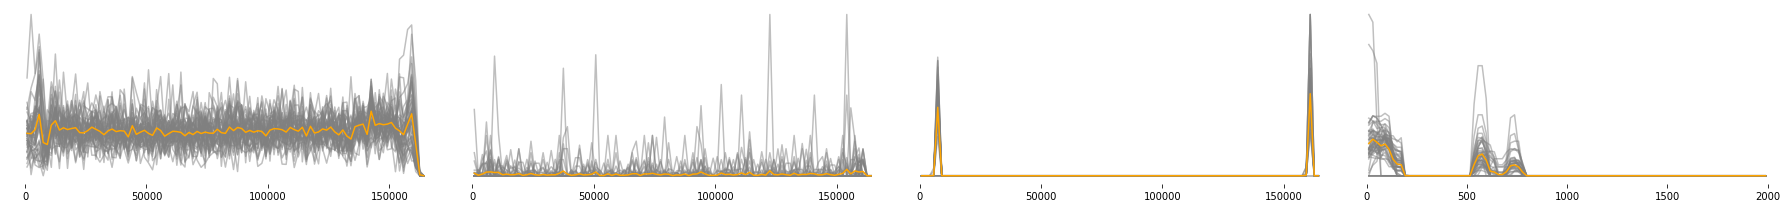

In [79]:
herpes_6B_medium = df_virus[(df_virus['Human herpesvirus 6B']>1000) & (df_virus['Human herpesvirus 6B']<10000)].sort_values('family').index
coverage_dicts = dict()
for sample in herpes_6B_medium:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_medium')
plt.show()

# Herpes 6B -- Not integrated

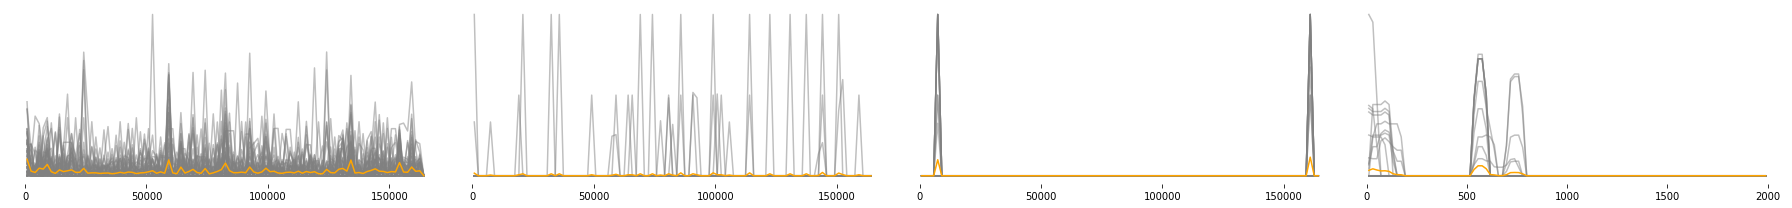

In [80]:
herpes_6B_low = df_virus[(df_virus['Human herpesvirus 6B']<500) & (df_virus['Human herpesvirus 6B']>10)].sort_values('family').index
coverage_dicts = dict()
for sample in herpes_6B_low:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)
CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_6B_low')
plt.show()

In [84]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_6B_'
contig_names = {'VIRL|gi|9633069|ref|NC_000898.1|'}

herpes_6B = df_virus[(df_virus['Human herpesvirus 6B']>10)].index
coverage_dicts = dict()
for sample in herpes_6B:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

samples = list(coverage_dicts.keys())
decoy_coverage = np.array([len(coverage_dicts[c]['decoy_coverage'])/(len(np.unique(coverage_dicts[c]['decoy_coverage']))+1) for c in coverage_dicts])
mated_w_decoy_coverage = np.array([len(coverage_dicts[c]['mated_with_decoy_coverage'])/(1+len(np.unique(coverage_dicts[c]['mated_with_decoy_coverage']))) for c in coverage_dicts])
proper_coverage = np.array([len(coverage_dicts[c]['proper_coverage'])/160000 for c in coverage_dicts])
mated_with_unmapped_coverage = np.array([len(coverage_dicts[c]['mated_with_unmapped_coverage'])/(1+len(np.unique(coverage_dicts[c]['mated_with_unmapped_coverage']))) for c in coverage_dicts])
df = pd.DataFrame([decoy_coverage, mated_w_decoy_coverage, proper_coverage, mated_with_unmapped_coverage]).transpose()
df.columns = ['decoy_coverage', 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']
df['colors'] = ['likely inherited' if i in herpes_6B_inherited else 'unknown' for i in samples]

<Figure size 720x720 with 0 Axes>

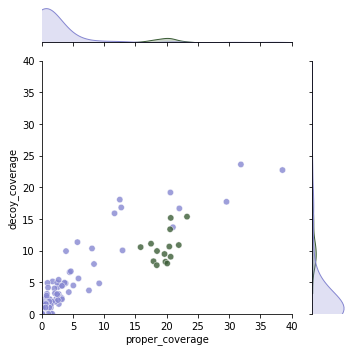

In [100]:
for x in ['proper_coverage']:#, 'mated_w_decoy_coverage', 'proper_coverage', 'mated_with_unmapped_coverage']:
    for y in ['decoy_coverage']:#, 'mated_w_decoy_coverage', '', 'mated_with_unmapped_coverage']:
        if x<=y: continue
        plt.figure(figsize=(10,10))
        g=sns.jointplot(data=df, x=x, y=y, hue='colors', palette=['#8687d1', '#3b5c36'], height=5,  s=40, alpha=.8)
        g.ax_joint.legend().remove()
        g.ax_marg_x.set_xlim(0, 40)
        g.ax_marg_y.set_ylim(0, 40)
        plt.xlabel('total reads ratio')
        plt.ylabel('decoy:virus ratio')
        plt.tight_layout()
plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_6B_total_vs_decoy.png', transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

# Herpes 7

In [81]:
herpes_7_high = bam_mappings.loc[df_virus[df_virus['Human herpesvirus 7']>1000].sort_values('family').index]
fams = herpes_7_high.groupby('family').count()
herpes_7_high[[f in list(fams[fams.status>0].index) for f in herpes_7_high.family]]

,status,participant_id,family,AGRE Blood,NIMH Blood,relationship,FatherID,MotherID,sex_numeric,derived_affected_status,...,number_of_indels,number_of_homozygous_snvs,number_of_heterozygous_snvs,het_to_hom_ratio,ti_tv_ratio,dbsnp_overlap,concordance_with_genotyping_chip,cryptic_relatedness_check,family_based_average_coverage,familial_relationship_check
05C43231-2,Passed_QC_analysis_ready,AU0025312,AU0025,HI3857,05C43231,sibling,AU0025211,AU0025212,2.0,broad-spectrum,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HI0385,Passed_QC_analysis_ready,AU013203,AU0132,HI0385,NaN,sibling,AU013202,AU013201,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HI0609,Passed_QC_analysis_ready,AU013205,AU0132,HI0609,NaN,sibling,AU013202,AU013201,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03C21410,Passed_QC_analysis_ready,AU0316301,AU0316,HI2699,03C21410,sibling,AU0316201,AU0316202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HI0366,Passed_QC_analysis_ready,AU032504,AU0325,HI0366,NaN,sibling,AU032502,AU032501,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09C89180,Passed_QC_analysis_ready,AU2607202,AU2607,HI9453,09C89180,mother,0,0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09C98429,Passed_QC_analysis_ready,AU2757303,AU2757,HI9871,09C98429,sibling,AU2757201,AU2757202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09C88944,Passed_QC_analysis_ready,AU2887304,AU2887,HI9438,09C88944,sibling,AU2887201,AU2887202,1.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09C88903,Passed_QC_analysis_ready,AU3197301,AU3197,HI9426,09C88903,sibling,AU3197201,AU3197202,2.0,autism,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


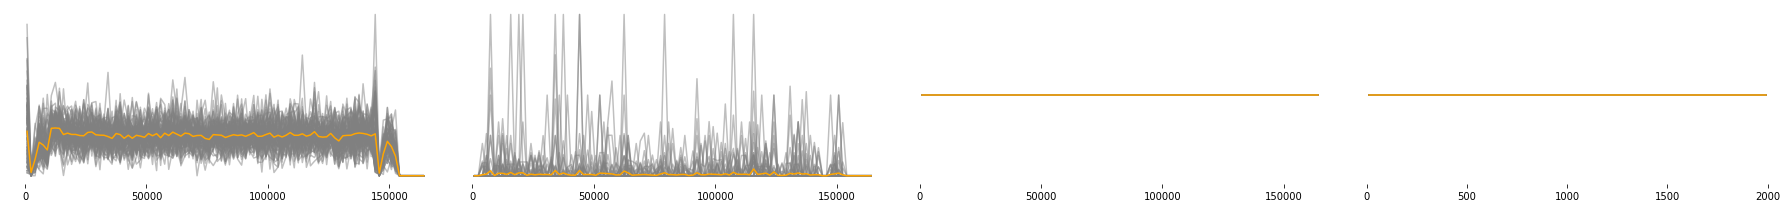

In [86]:
coverage_dir = '/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/herpes_coverages/herpes_7_'
contig_names = {'VIRL|gi|51874225|ref|NC_001716.2|'}
herpes_7_high = df_virus[df_virus['Human herpesvirus 7']>1000].sort_values('family').index

coverage_dicts = dict()
for sample in herpes_7_high:
    if sample=='03C16028': continue
    filename = coverage_dir + sample + '.npy'
    if len(glob.glob(filename))>0:
        coverage_dicts[sample] = np.load(filename, allow_pickle=True).item()
    else:
        print(sample)
        coverage_dicts[sample] = GetCoverage(sample, contig_names, filename)

CoverageHistograms(coverage_dicts, np.linspace(0,165000,100), np.linspace(0,2000,100))
saveHighResFig('herpes_7')
plt.show()

## Herpes 7 -- High Load

In [55]:
try:
    df_herpes_7 = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_high.csv')
except:
    samples = [i for i in bam_mappings.loc[df_virus[(df_virus['Human herpesvirus 7']>5000)].sort_values('family').index].index if i !='03C16028']
    dfs_herpes_7 = [None for s in samples]
    for i,sample in enumerate(samples):
        print(sample)
        filename=glob.glob('/scratch/users/chloehe/unmapped_reads/bam/*/%s/%s.final_alignment_table.csv' % (sample, sample))[0]
        df = pd.read_csv(filename)
        df = df[(np.array([r in herpes_7_contigs for r in df.R1_ref])) | (np.array([r in herpes_7_contigs for r in df.R2_ref]))]
        df['sample']= sample
        dfs_herpes_7[i] = df
    #df_herpes_7 = pd.concat(dfs_herpes_7)
    #df_herpes_7.to_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_high.csv')

In [ ]:
CoverageHistograms(100, df_herpes_7,df_herpes_7,{'VIRL|gi|51874225|ref|NC_001716.2|'}, 'chrUn_JTFH01000690v1_decoy')
plt.tight_layout()
plt.savefig('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/paper/viral_integration/herpes_7_high.png',transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

## Herpes 7 -- Low load

In [396]:
samples = df_virus.loc[df_virus[(df_virus['Human herpesvirus 7']>10) & (df_virus['Human herpesvirus 7']<100)].sort_values('family').index]['Human herpesvirus 7'].index
print(sum(df_virus.loc[df_virus[(df_virus['Human herpesvirus 7']>10) & (df_virus['Human herpesvirus 7']<100)].sort_values('family').index]['Human herpesvirus 7']))
print(' '.join(samples))

3390.0
03C16014 03C16830 03C16034 02C12061 HI1146 05C40754 02C11625 05C45653 03C23223 05C44398 04C31673 03C21394 03C21394_LCL 04C31446 04C34137 05C50279 05C40019 05C40018 05C50288 05C47182 05C41367 04C35437 MH0134528 05C41994 04C37212 05C43238 05C50296 05C44474 04C37401 05C41357 05C45016 05C39267 06C52791 05C45450 05C44888 05C43258 05C45644 05C42701 05C43270 05C43828 05C44773 06C53579 05C47181 05C48976 05C51754 05C50306 05C48308 05C51556 05C48534 05C50070 06C53575 09C85276 05C51553 06C61140 06C55451 07C69751 07C69749 09C85275 09C85057 07C62597 08C73545 07C65183 07C66479 08C77269 07C66656 07C68916 07C66884 07C65977 07C69308 08C77365 07C69442 09C80267 09C86460 08C73791 10C114756 10C107310 08C77359 09C98376 09C82356 10C104045 11C122174 09C89701 09C86828 10C112859 10C108231 10C111728 10C112907 MH0143019 MH0130591


In [375]:
%%bash
\rm  /scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_6B_low.csv
for s in 03C16014 03C16830 03C16034 02C12061 HI1146 05C40754 02C11625 05C45653 03C23223 05C44398 04C31673 \
03C21394 03C21394_LCL 04C31446 04C34137 05C50279 05C40019 05C40018 05C50288 05C47182 05C41367 04C35437 \
MH0134528 05C41994 04C37212 05C43238 05C50296 05C44474 04C37401 05C41357 05C45016 05C39267 06C52791 05C45450 \
05C44888 05C43258 05C45644 05C42701 05C43270 05C43828 05C44773 06C53579 05C47181 05C48976 05C51754 05C50306 \
05C48308 05C51556 05C48534 05C50070 06C53575 09C85276 05C51553 06C61140 06C55451 07C69751 07C69749 09C85275 \
09C85057 07C62597 08C73545 07C65183 07C66479 08C77269 07C66656 07C68916 07C66884 07C65977 07C69308 08C77365 \
07C69442 09C80267 09C86460 08C73791 10C114756 10C107310 08C77359 09C98376 09C82356 10C104045 11C122174 09C89701 \
09C86828 10C112859 10C108231 10C111728 10C112907 MH0143019 MH0130591; do
    echo $s
    grep NC_001716.2 $(ls /scratch/users/chloehe/unmapped_reads/bam/*/$s/$s.final_alignment_table.csv) >> /scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_low.csv
done




Process is interrupted.


In [ ]:
ls /scratch/users/chloehe/unmapped_reads/bam/*/06C55451/06C55451.final_alignment_table.csv

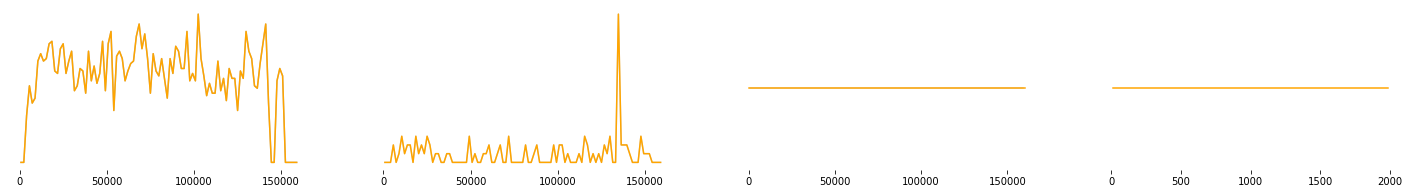

In [599]:
df_herpes_7 = pd.read_csv('/scratch/groups/dpwall/personal/briannac/unmapped_reads/microbes/results/dfs_herpes_7_low.csv', header=None)
df_herpes_7.columns = ['Unnamed:', 'R1_ref', 'R1_start', 'R1_MAPQ','R1_is_reverse', 'R2_ref', 'R2_start', 'R2_MAPQ', 'R2_is_reverse','is_proper_pair']
df_herpes_7['sample'] = 'combined'
counters_7_no_int = CoverageHistograms(100, df_herpes_7,herpes_7_contigs,{'VIRL|gi|51874225|ref|NC_001716.2|'}, 'chrUn_JTFH01000690v1_decoy',decoy_seq_bins=np.linspace(0,2000,100))


# Make table

In [139]:
hhv_summary = pd.DataFrame(np.zeros((6,3)), columns=['6A', '6B', '7'])